<center><h1>INF580</h1></center>
<h3 align = 'center'>Sentence similarity using graph-of-words representation embeddings</h3>
<center><h5>Kniazev Leonid - Sattarov Tagir</h5></center>

**Project idea 2**: Create a graph-of-words from a sentence, enrich it with semantic distances, then use the DG methods in these lectures to embed the graph in a low-dimensional space; then evaluate sentence similarity using vector angles.

## 0. Import all the libraries

In [2]:
import sys
import string

import numpy as np
import numpy.linalg as la
import tqdm
import numba
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as dist
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import spacy

from amplpy import AMPL
import cvxpy as cp
import dgp_sdp

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. DATA PREPARATION

### 1.1 Datasets loading

In order to create a graph-of-words from text corpus, we will use two datasets.

The first is the pairs of english sentences and their similarities annotated by humans from SemEval-2017 contest (test set).

USE_TRAIN is used to enrich our graph with some adiitional data. We chose 1M words dataset of movies subtitles as additionnal data from "https://www.corpusdata.org/" for our graph of words (train set). It has a lot of different styles of coversations and has ~20 times more lemmas than the test set from SemEval-2017. 

Below you can find the 5 first pairs of sentences. As we can see they are not long and we can suppose that in this case graphs will not give us a lot of information about sentences.

At the same time, word-to-vec representation for a sentence will be meaningful and will keep information about most significant parts of sentences.



In [3]:
USE_TRAIN = True
DAT_FILE = 'dist_graph.dat'
with open('input.txt') as f:
    lines_test = [line.strip() for line in f]
with open('movies_text.txt') as f:
    lines_train = [line.strip() for line in f]

print(len(lines_test))
print(lines_test[:5])

250
['A person is on a baseball team.\tA person is playing basketball on a team.', 'Our current vehicles will be in museums when everyone has their own aircraft.\tThe car needs to some work', 'A woman supervisor is instructing the male workers.\tA woman is working as a nurse.', 'A bike is next to a couple women.\tA child next to a bike.', 'The group is eating while taking in a breathtaking view.\tA group of people take a look at an unusual tree.']


### 1.2 Preprocessing : remove punctuation, stopwords and lemmatize
We will work with sentences without punctuation marks. We also remove stopwords and lemmatize all the words.

Below we explain important variables that we used in our project:

"words" is a dictionary with all the lemmas that we have in our test and train sets. word["cat"] := index of "cat".

"test_words" is the same thing with lemmas only from the test set.

"sentences_test" is already cleaned test set with sentences represented as pairs of lists of word indexes.

"sentences_train" the same thing for the train set.

We use the information from the train dataset and we evaluate it on the test dataset.

In [4]:
stopwords_en = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()
lemmas = set(wordnet.all_lemma_names())

words = dict()
test_words = dict()
sentences_test = list()

for line in lines_test:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            words.setdefault(w, len(words))
            test_words.setdefault(w, len(test_words))
            v.append(words[w])

    sentences_test.append((v1, v2))

sentences_train = list()
if USE_TRAIN:
    for s in lines_train:
        v = []
    
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            
            words.setdefault(w, len(words))
            v.append(words[w])

        sentences_train.append(v)

In [5]:
print(len(words.keys()))
print(len(test_words.keys()))

18669
687


## 2. Main Algorithm

### 2.1 Make synonyms graph
First, we create a graph representing synonyms. For that, we use **wordnet** synonyms.

In **synonym_graph**, synonym_graph[i][j] is 1, iff the word words[i] and the word words[j] are synonyms.

In [7]:
synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in stopwords_en:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1
if USE_TRAIN:
    synonym_graph = synonym_graph[:len(test_words), :len(test_words)]

In [7]:
print(synonym_graph.shape)

(687, 687)


We give you an example of a set of synonyms for the first word in the dictionary.

We see that there are 3 synonyms for "person" in the corpus.

In [8]:
print(list(words.keys())[0])
print(set_of_synonyms(list(words.keys())[0]))
print(sum(synonym_graph[0]))

person
{'somebody', 'soul', 'someone', 'individual', 'mortal', 'person'}
3.0


### 2.2 Make sliding window graph
Now, we create a sliding window graph.

**window_size** is a parameter. Each time two words words[i] and words[j] are in sliding window, we add 1 to window_graph[i][j].

In [9]:
window_size = 3

window_graph_train = np.zeros((len(words), len(words)))

for ss in sentences_test:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    for s in sentences_train:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    window_graph = window_graph_train[:len(test_words), :len(test_words)]
else:
    window_graph = window_graph_train

In [10]:
print(window_graph.shape)

(687, 687)


### 2.3 Make Spacy dependency tree graph

Here we create a graph representing sentence syntactic.

We work with **spaCy** dependency trees. **spaCy** uses the terms head and child to describe the words connected by a single arc in the dependency tree. Because the syntactic relations form a tree, every word has exactly one head. We can therefore iterate over the arcs in the tree by iterating over the words in the sentence.

In [11]:
dependency_graph = np.zeros((len(test_words), len(test_words)))
translation_table = str.maketrans('', '', string.punctuation)

nlp = spacy.load("en_core_web_lg")

for i in range(len(lines_test)):
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = ' '.join([w for w in sent1.split()])
    sent2 = ' '.join([w for w in sent2.split()])
    sent1 = nlp(sent1)
    sent2 = nlp(sent2)

    for s in [sent1, sent2]:
        for w in s: #iteration over the words in the sentence
            w1 = w.text.lower().translate(translation_table)
            w2 = w.head.text.lower().translate(translation_table)

            if (not w1 in stopwords_en) & (not w2 in stopwords_en) & (w.dep_ != "ROOT") & (w.dep_ != "punct"):
                w1 = lemmatizer.lemmatize(w1)
                w2 = lemmatizer.lemmatize(w2)
                if (w1 in test_words) & (w2 in test_words):
                    dependency_graph[test_words[w1]][test_words[w2]] += 1
                    dependency_graph[test_words[w2]][test_words[w2]] += 1

We show you the number of words in syntactic dependacies with "person" in the corpus.

In [12]:
print(sum(dependency_graph[0]))

19.0


### 2.4 Combine synonym, window graphs and dependency graph

Now, in order to use the information on synonyms, word order in sentences and syntactic dependencies, we put 3 graps together.

Then we complete distance matrix with shortest path lengths.

# To complete

In [13]:
print(synonym_graph.shape, window_graph.shape, dependency_graph.shape)
distances = 1 / (synonym_graph + window_graph + dependency_graph + 1)
#gr_max = np.max(synonym_graph + window_graph + dependency_graph)
#distances = gr_max - (synonym_graph + window_graph + dependency_graph) + 1
for i in range(distances.shape[0]):
    for j in range(distances.shape[0]):
        if distances[i][j] == 1:
            distances[i][j] = -1.0

np.fill_diagonal(distances, 0)

def floyd_warshall(dist):
    n = dist.shape[0]
    for u in tqdm.trange(n):
        for v in range(n):
            if dist[u][v] == -1.0:
                dist[u][v] = 10e6

    @numba.jit
    def h(dist, n, z):
        for u in range(n):
            for v in range(n):
                if (dist[u][v] > dist[u][z] + dist[z][v]):
                    dist[u][v] = dist[u][z] + dist[z][v]

    for z in tqdm.trange(n):
        h(dist, n, z)
        
    
floyd_warshall(distances)

if np.max(distances) == 10e6:
    print("Distances graph is not connected")
else:
    print("Distances graph is connected")

(687, 687) (687, 687) (687, 687)


100%|██████████| 687/687 [00:02<00:00, 277.98it/s]

Distances graph is connected


## 3 Distance Geometry

### 3.1 MDS


In this part we produce an approximate realisation of $x$.

We have an approximate EDMs $\tilde{D}$ from raw data completed with Floyd-Warshall algorithm. Then we compute an approximate Gram matrix:

$$ \tilde{G} = - \frac{1}{2} J \tilde{D}^2 J, $$

where $J = I_n - \frac{1}{n}\mathbb{1}\mathbb{1}^{T}$.

Having spectral decomposition of $\tilde{G} = P \tilde{\Lambda} P^{T}$, we find $\Lambda$ the PSD diagonal matrix closest to $\tilde{\Lambda}$.

$\Lambda$ is obtained from $\tilde{\Lambda}$ by zeroing negative components.

So, finally, $x = P \sqrt{\Lambda}$.

To move $\bar{x}$ to $0$, we reduce all the x by their mean. 

In [14]:
@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

In [15]:
#this function creates a .dat file in convinient for AMPL format based on subgraphs matrices
def print_dat(distances):
    with open(DAT_FILE, 'w') as f:
        #sys.stdout = f # Change the standard output to the file we created.
        f.write("param Kdim := 3;\nparam n := {};\nparam : E : c I :=\n".format(distances.shape[0]))
        for i in tqdm.trange(distances.shape[0]):
            for j in range(distances.shape[0]):
                if i-j==0:
                    continue
                f.write("{} {} {} 1\n".format(i+1, j+1, distances[i, j]))
        f.write(";")
        f.close()

### 3.2 General Pipeline

We can follow these steps:

1) We may use SDP relaxation for DGP. Its solution yields $n \times n$ PSD matrix $X^{*}$.

2) At the end, we need $n \times K$ realization matrix $x^{*}$, so we apply PCA to $X^{*}$, keep $K$ largest comps, get $x^{\prime}$.

3) As this yields solutions with errors, we use $x^{\prime}$ as starting point for local NLP solver.

For the first part, we may also use DDP, an approximation for SDP. In this case, DDP could be infeasible.

We may also use DualDDP which is a relaxation of SDP, and so, this is a relaxation of the original problem.

Three possible methods would be:

I. SDP -> PCA -> NLP

II. DDP -> PCA -> NLP

III. DualDDP -> PCA -> NLP


#### 3.2.1 SDP

#### SDP relaxation

Let's consider the system of quadratic equations

$$
\forall\{u, v\} \in E \quad\left\|x_{u}-x_{v}\right\|^{2}=d_{u v}^{2}
$$

We can add a new variable matrix $X$ s.t. $X_{i j} = x_i x_j$:

$$
\begin{aligned}
&\Rightarrow \forall\{i, j\} \in E \quad\left\|x_{i}\right\|_{2}^{2}+\left\|x_{j}\right\|_{2}^{2}-2 x_{i} \cdot x_{j}=d_{i j}^{2} \\
&\Rightarrow\left\{\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X &=x x^{\top}
\end{aligned}\right.
\end{aligned}
$$

Now we will add a relaxation, so we change $X-x x^{\top}=0$ to $X-x x^{\top} \succeq 0$.

Then we can replace $\operatorname{Schur}(X, x)=\left(\begin{array}{cc}
I_{K} & x^{\top} \\
x & X
\end{array}\right)\succeq 0$ by $$X \succeq 0,$$ because $x$ is not used elsewhere.

One of proposed methods gives an MP

$$
\begin{aligned}
\min F \bullet X =
\operatorname{tr}\left(F^{\top} X\right)
& \\
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \succeq 0
\end{aligned}
$$

We should choose the objective function, so we use a common one:

$$
\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)
$$


In [16]:
def sdp(DAT_FILE, showplot=False):
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w

    ## MP formulation: vars, obj, constrs
    X = cp.Variable((n,n), PSD=True)

    cobj1 = sum([X[i,i] + X[j,j] - 2*X[i,j] for i in range(n) for j in G[i] if i<j])
    objective = cp.Minimize(cobj1)

    constraints = [X[i,i] + X[j,j] - 2*X[i,j] == G[i][j]**2 for i in range(n) for j in G[i] if i<j]
    prob = cp.Problem(objective, constraints)

    ## solve the problem
    prob.solve(solver=cp.SCS, verbose=True)

    objfunval = prob.value
    print("optimal obj. fun. value =", objfunval)
    if X.value is None:
        return (None, False)

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n) 
    
    Y = dgp_sdp.MDS(X.value)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X.value, K)
        
    ## report SDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("SDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("SDP largest distance error =", lderr1)

    from amplpy import Environment

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if dgp_sdp.showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()
    return (x, True)

#### 3.2.2 DDP


SDP solver is a bottleneck in the Method 3.2.1. To avoid testing a matrix for SDP, we would like to work with LP problem instead.

For this reason, we introduce diagonally dominant (DD) matrices:

$n \times n$ symmetric matrix $X$ is DD if
$$
\forall i \leq n \quad X_{i i} \geq \sum_{j \neq i}\left|X_{i j}\right| \quad (*)
$$

Every DD matrix is PSD.

Before we had an MP such that

\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \succeq 0
\end{aligned}

Our approximation gives

\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \text{ is DD} \quad (*)
\end{aligned}

We may linearize (*) consrtaints by using an additional matrix variable $T$:

$$
(*) \Rightarrow \begin{aligned}
\forall i \leq n & \sum_{\substack{j \leq n \\
j \neq i}} T_{i j} \leq X_{i i} \\
& -T \leq X\leq T \\
& T \geq 0
\end{aligned}
$$

Considering the fact that DDP approximation could be infeasible, we will enlarge the feasible region.

We make a change:

$$
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j}=d_{i j}^{2}
$$

is now relaxed

$$
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} \geq d_{i j}^{2}
$$

An SDP problem becomes linear, but we need to use a specific objective function due to introduced relaxation:

$$
\begin{aligned}
&\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)\\
&\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} & \geq d_{i j}^{2} \\
\forall i \leq n \quad \sum_{j \leq n, i \neq j} T_{i j} & \leq X_{i i} \\
-T \leq X & \leq T \\
T & \geq 0
\end{aligned}
\end{aligned}
$$

In [17]:
def ddp(DAT_FILE, showplot=False):
    # read instance
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    from amplpy import Environment
    ddp = AMPL(Environment('../ampl'))
    ddp.read("dgp_ddp.mod")
    ddp.readData('./' + DAT_FILE)
    ddp.setOption('solver', dgp_sdp.LPsolver)
    ddp.solve()
    objfun = ddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = ddp.getVariable('X')

    #if Xvar.value() is None:
    #    return (None, False)

    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X, K)

    ## report dualDDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("DDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("DDP largest distance error =", lderr1)

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()
    return (x, True)

#### 3.2.3 Dual Cone DDP

Let C be a cone if:
$$\forall A, B \in C, \alpha, \beta \geq 0 \quad \alpha A+\beta B \in C$$
and $C^{*}=\{y \mid \forall x \in C \quad \langle x, y\rangle \geq 0\}$ its dual cone.

We will use $\mathcal{X}_{\mathbb{D D}}=\left\{e_{i} \mid i \leq n\right\} \cup\left\{\left(e_{i} \pm e_{j}\right) \mid i<j \leq n\right\}$ where $e_i$ is the $i^{th}$ basis element of $\R^n$.

$\mathcal{X}_{\mathbb{D D}}$ finitely generates the set of Diagonally Dominant matrices which is denoted as $\mathbb{D D}$. We mention that $|\mathcal{X}_{\mathbb{D D}}| = |O(n^2)|$

Using the finitely generated dual cone theorem, we know that $$DD^* = \left\{Y\mid \forall x \in \mathcal{X}_{\mathbb{D D}}\left(Y \bullet x x^{\top} \geq 0\right) = \left(x^{\top} Y x \geq 0\right) \right\}$$

As $\mathbb{D D}^{*} \supset \mathbb{P S D}$, we may use an relaxation of SDP.

So, we change the formulation of SDP for our DGP and we take 
condition $\forall v \in \mathcal{X}_{\mathbb{D D}}~~ v^{\top} X v \geq 0$ instead of $ X \succeq 0$. 

And the final Dual cone DDP formulation for DGP is
$$\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)\\
\forall\{i, j\} \in E ~~~~  X_{i i}+X_{j j}-2 X_{i j} =d_{i j}^{2}  \\
\forall i \leq n \quad X_{i i} \geq 0\\
\forall\{i, j\} \notin E \quad X_{i i}+X_{j j}-2 X_{i j} \geq 0\\
\forall i<j \quad X_{i i}+X_{j j}+2 X_{i j} \geq 0
$$


In [18]:
def dualddp(DAT_FILE, showplot=False):
    # read instance
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    from amplpy import Environment
    dualddp = AMPL(Environment('../ampl'))
    dualddp.read("dgp_dualddp.mod")
    dualddp.readData('./' + DAT_FILE)
    dualddp.setOption('solver', dgp_sdp.LPsolver)
    dualddp.solve()
    objfun = dualddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = dualddp.getVariable('X')
    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X, K)

    ## report dualDDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("dualDDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("dualDDP largest distance error =", lderr1)

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()

    return (x, True)

## 4 Results

### 4.1 Visualisation in 2D 

Next plot gives us a visualisation of the result on 2D. Then we will use k = 20 dimensions.

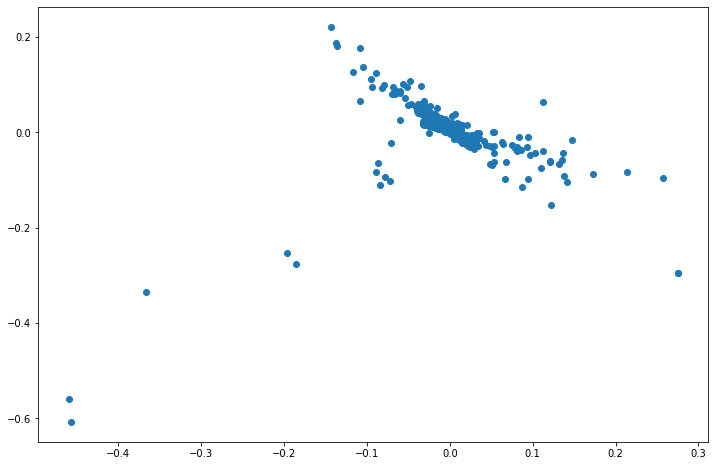

In [19]:
k=20
word_to_vec = embed_graph(distances, k)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

#### Application of methods for  for subgraphs l


In [20]:
print_dat(distances)
sdp_distances, result = sdp(DAT_FILE, showplot=False)


100%|██████████| 687/687 [00:01<00:00, 509.01it/s]


In [ ]:
print(result)
#print(sdp_distances)

In [ ]:
N_printed_sents = 1
nlp = spacy.load('en_core_web_lg')
with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
ampl_res = []
idx = []

if False:
    for i, (s1, s2) in enumerate(sentences_test):
        
        subgraph1 = distances[np.ix_(s1, s1)]
        subgraph2 = distances[np.ix_(s2, s2)]
        print_dat(subgraph1)
        result1, suc1 = sdp(DAT_FILE, showplot=False)
        print_dat(subgraph2)
        result2, suc2 = sdp(DAT_FILE, showplot=False)
        if not (suc1 & suc2):
            ampl_res.append(0)
            continue
        v1 = np.mean(result1, axis=0)
        v2 = np.mean(result2, axis=0)
        if v1.shape != v2.shape:
            ampl_res.append(0)
            continue
        d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
        ampl_res.append(d)
        print(i, "{:1.8f} {:1.8f}".format(train[i] / 5, d), lines_test[i], sep='\t')
        idx.append(i)
        if i > N_printed_sents:
            break

In [ ]:
#N_printed_sents = 250
nlp = spacy.load('en_core_web_lg')
with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
ampl_res = []
idx = []

for i, (s1, s2) in enumerate(sentences_test):
    if (len(s1) < 3) or (len(s2) < 3):
        ampl_res.append(0)
        continue
    #if i > N_printed_sents:
    #    break
    subgraph1 = distances[np.ix_(s1, s1)]
    subgraph2 = distances[np.ix_(s2, s2)]
    print_dat(subgraph1)
    #result1, suc1 = sdp(DAT_FILE, showplot=False)
    #result1, suc1 = ddp(DAT_FILE, showplot=False)
    result1, suc1 = dualddp(DAT_FILE, showplot=False)
    print_dat(subgraph2)
    #result2, suc2 = sdp(DAT_FILE, showplot=False)
    #result2, suc2 = ddp(DAT_FILE, showplot=False)
    result2, suc2 = dualddp(DAT_FILE, showplot=False)
    if not (suc1 & suc2):
        ampl_res.append(0)
        continue
    v1 = np.mean(result1, axis=0)
    v2 = np.mean(result2, axis=0)
    if v1.shape != v2.shape:
        ampl_res.append(0)
        continue
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    ampl_res.append(d)
    print(i, "{:1.8f} {:1.8f}".format(train[i] / 5, d), lines_test[i], sep='\t')
    idx.append(i)

CPLEX 20.1.0.0: optimal solution; objective 0.2335011239
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.23350112385933436
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0042168517741068
dualDDP largest distance error = 0.010249890819175517
Cannot find "ipopt"
NLP mean distance error = 0.0042166074169006544
NLP largest distance error = 0.010249946818752242
CPLEX 20.1.0.0: optimal solution; objective 0.3760642746
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3760642745501733
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01196827816825398
dualDDP largest distance error = 0.03663812098699798



100%|██████████| 4/4 [00:00<00:00, 41323.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011968233261094063
NLP largest distance error = 0.03663805792551589
CPLEX 20.1.0.0: optimal solution; objective 3.771873167
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.771873167467543
ambient dimension n = 4



100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]

found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.022664076278235395
dualDDP largest distance error = 0.054486042357024034
Cannot find "ipopt"
NLP mean distance error = 0.02266428134460056
NLP largest distance error = 0.05448571413253067
CPLEX 20.1.0.0: optimal solution; objective 0.002218660112
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.0022186601121670564
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00044203530094850144
dualDDP largest distance error = 0.0007246731277362438



100%|██████████| 4/4 [00:00<00:00, 27191.60it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0004420327616223493
NLP largest distance error = 0.0007246998902530125
CPLEX 20.1.0.0: optimal solution; objective 1.513870125
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5138701253103377
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01457755546956741
dualDDP largest distance error = 0.0418003715291822



100%|██████████| 3/3 [00:00<00:00, 24624.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014577527664567061
NLP largest distance error = 0.041800601273779825
CPLEX 20.1.0.0: optimal solution; objective 0.1681075302
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.16810753024577615
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006535626769095494
dualDDP largest distance error = 0.01209861936333892
Cannot find "ipopt"
NLP mean distance error = 0.006535821784945888



100%|██████████| 4/4 [00:00<00:00, 44034.69it/s]

NLP largest distance error = 0.012098556167850355
CPLEX 20.1.0.0: optimal solution; objective 0.352356508
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3523565079861019
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0006060548834992187
dualDDP largest distance error = 0.0010407441325271174



100%|██████████| 3/3 [00:00<00:00, 35951.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0006060068691737379
NLP largest distance error = 0.0010407017650153338
CPLEX 20.1.0.0: optimal solution; objective 0.2038521554
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2038521554249576
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.012009851594868176
dualDDP largest distance error = 0.01643953745027117



100%|██████████| 5/5 [00:00<00:00, 46294.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012009924940919703
NLP largest distance error = 0.016439583262818205
CPLEX 20.1.0.0: optimal solution; objective 2.561879314
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.561879314452712
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04120659572813639
dualDDP largest distance error = 0.1764753169351796



100%|██████████| 6/6 [00:00<00:00, 48960.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04120665125117906
NLP largest distance error = 0.1764750822545318
CPLEX 20.1.0.0: optimal solution; objective 0.8629534254
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8629534253592966
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012942393724567128
dualDDP largest distance error = 0.04665678670376279



100%|██████████| 3/3 [00:00<00:00, 29817.33it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012942300511616378
NLP largest distance error = 0.04665670672634101
4	0.44000000 0.25923064	The group is eating while taking in a breathtaking view.	A group of people take a look at an unusual tree.
CPLEX 20.1.0.0: optimal solution; objective 0.1545359324
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.15453593244730002
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.009828081389201515
dualDDP largest distance error = 0.026488773125903545



100%|██████████| 3/3 [00:00<00:00, 34007.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00982831224222991
NLP largest distance error = 0.02648874275075886
CPLEX 20.1.0.0: optimal solution; objective 0.1492889182
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.14928891824515494
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00964350051666627
dualDDP largest distance error = 0.02614597753045407



100%|██████████| 7/7 [00:00<00:00, 43561.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009643481767692752
NLP largest distance error = 0.026145972402783546
5	0.68000000 0.99985729	The boy is raising his hand.	The man is raising his hand.
CPLEX 20.1.0.0: optimal solution; objective 6.274432693
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.274432692934801
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02504966419915754
dualDDP largest distance error = 0.08405660717010249



100%|██████████| 4/4 [00:00<00:00, 44620.26it/s]


Cannot find "ipopt"
NLP mean distance error = 0.02504969134207724
NLP largest distance error = 0.08405661783173146
CPLEX 20.1.0.0: optimal solution; objective 0.6542397138
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6542397138196939
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014840455145024687
dualDDP largest distance error = 0.03922431879612795


100%|██████████| 3/3 [00:00<00:00, 38479.85it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014840548576997778
NLP largest distance error = 0.039224451940098715
6	0.16000000 0.11667054	A man with a gray beard is being shaved in front of a lecture hall	A man with a beard is sitting in the grass.
CPLEX 20.1.0.0: optimal solution; objective 0.3050800001
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.305080000066223
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004751806766404539
dualDDP largest distance error = 0.00816927473073717



100%|██████████| 7/7 [00:00<00:00, 46236.42it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0047520781593872186
NLP largest distance error = 0.008169530458596336
CPLEX 20.1.0.0: optimal solution; objective 1.680327088
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6803270877240584
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009100314426138702
dualDDP largest distance error = 0.027543159455071207



100%|██████████| 7/7 [00:00<00:00, 31134.81it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00910034273480191
NLP largest distance error = 0.027543217922922542
CPLEX 20.1.0.0: optimal solution; objective 3.796888768
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.7968887678270455
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0345351752926333
dualDDP largest distance error = 0.11710910116440654



100%|██████████| 6/6 [00:00<00:00, 31107.32it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03453513354277519
NLP largest distance error = 0.11710863003460076
CPLEX 20.1.0.0: optimal solution; objective 5.451787677
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.451787677455022
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02784183384666891
dualDDP largest distance error = 0.09414937226828196



100%|██████████| 4/4 [00:00<00:00, 45714.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02784182888540531
NLP largest distance error = 0.09414965015888388
8	0.08000000 0.55445489	The young boy jumps barefoot outside in the front yard.	The teen rode his bike around the people walking in the courtyard.
CPLEX 20.1.0.0: optimal solution; objective 1.434099106
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4340991057682644
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014966849550017878
dualDDP largest distance error = 0.041184512699918366



100%|██████████| 7/7 [00:00<00:00, 9229.84it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01496654805446679
NLP largest distance error = 0.041184314445672734
CPLEX 20.1.0.0: optimal solution; objective 0.3471732492
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.34717324918704645
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009191617161023066
dualDDP largest distance error = 0.02513052795409297



100%|██████████| 7/7 [00:00<00:00, 49678.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009191687885945831
NLP largest distance error = 0.02513052657610379
10	0.68000000 0.66846941	Some cyclists stop near a sign.	Two men stop to talk near a sign outside.
CPLEX 20.1.0.0: optimal solution; objective 1.693672826
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6936728264691887
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.031759681626898795
dualDDP largest distance error = 0.10731364004697108



100%|██████████| 3/3 [00:00<00:00, 35645.64it/s]

Cannot find "ipopt"
NLP mean distance error = 0.031759534103355996
NLP largest distance error = 0.10731375713190645
CPLEX 20.1.0.0: optimal solution; objective 0.09273349266
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.09273349266174494
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.003918629816835463
dualDDP largest distance error = 0.007772718178930937



100%|██████████| 4/4 [00:00<00:00, 40820.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00391845612983203
NLP largest distance error = 0.007772706648655592
CPLEX 20.1.0.0: optimal solution; objective 0.1545442483
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1545442483136512
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00027369868096130287
dualDDP largest distance error = 0.0009182812021176698



100%|██████████| 4/4 [00:00<00:00, 42690.12it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00027351013935222646
NLP largest distance error = 0.0009182363210805192
CPLEX 20.1.0.0: optimal solution; objective 0.1323358059
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1323358058648577
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.001598820414837561
dualDDP largest distance error = 0.005606445569697874



100%|██████████| 3/3 [00:00<00:00, 32853.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0015987830536350223
NLP largest distance error = 0.00560647028328002
12	0.92000000 0.61711204	A young person  deep in thought.	A young man deep in thought.
CPLEX 20.1.0.0: optimal solution; objective 0.4456637708
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4456637707666514
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0006007269661060868
dualDDP largest distance error = 0.000933100355264227



100%|██████████| 3/3 [00:00<00:00, 31378.83it/s]

Cannot find "ipopt"
NLP mean distance error = 0.000601063903060675
NLP largest distance error = 0.0009335968365568603
CPLEX 20.1.0.0: optimal solution; objective 0.4456637708
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4456637707666514
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006717771561627361
dualDDP largest distance error = 0.010076657342440953



100%|██████████| 3/3 [00:00<00:00, 37449.14it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006717783569912177
NLP largest distance error = 0.010076654367213944
13	0.36000000 0.99999583	A man is carrying a canoe with a dog.	A dog is carrying a man in a canoe.
CPLEX 20.1.0.0: optimal solution; objective 0.2269892337
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.22698923373115815
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0017637330903759046
dualDDP largest distance error = 0.002971227598487919



100%|██████████| 3/3 [00:00<00:00, 35246.25it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0017638755780446426
NLP largest distance error = 0.0029714496900697107
CPLEX 20.1.0.0: optimal solution; objective 0.1362601678
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1362601678086433
ambient dimension n = 3
found relaxed embedding in natural dimension K = 1
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0028504265673802522
dualDDP largest distance error = 0.007087646104133399



100%|██████████| 7/7 [00:00<00:00, 50620.91it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0028507548902551422
NLP largest distance error = 0.007087687890938256
14	0.56000000 0.99783182	A man is performing labor.	A man is performing today.
CPLEX 20.1.0.0: optimal solution; objective 4.203100528
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.203100528264846
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01220741543955422
dualDDP largest distance error = 0.046951990559207846



100%|██████████| 10/10 [00:00<00:00, 40252.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012207397646720443
NLP largest distance error = 0.04695174054830656
CPLEX 20.1.0.0: optimal solution; objective 5.026593295
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.026593295166324
ambient dimension n = 10
found relaxed embedding in natural dimension K = 8
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.031285480132289246
dualDDP largest distance error = 0.11138118193546018



100%|██████████| 5/5 [00:00<00:00, 49932.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.031285499224931256
NLP largest distance error = 0.111381077417534
15	0.40000000 0.97240733	Two men wearing traditional clothing is standing outside.	Three women wearing black vests and gray shirts are talking outside of a building.
CPLEX 20.1.0.0: optimal solution; objective 0.492663074
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.49266307395077746
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0029024560255617336
dualDDP largest distance error = 0.016056885135294362



100%|██████████| 4/4 [00:00<00:00, 42690.12it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002902372394483108
NLP largest distance error = 0.01605686746016723
CPLEX 20.1.0.0: optimal solution; objective 0.2369620995
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.23696209953334882
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006518620595049983
dualDDP largest distance error = 0.019243605536695838



100%|██████████| 4/4 [00:00<00:00, 44150.57it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006518527800143709
NLP largest distance error = 0.019243564110137154
16	0.44000000 0.85005306	a woman watches a rap group live	An audience watches a girl dance.
CPLEX 20.1.0.0: optimal solution; objective 0.732135193
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7321351929641852
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01344039615309515
dualDDP largest distance error = 0.03579744821327363



100%|██████████| 3/3 [00:00<00:00, 34568.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013439858440478167
NLP largest distance error = 0.03579696846706143
CPLEX 20.1.0.0: optimal solution; objective 0.2399499849
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.23994998487985375
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006531727491512225
dualDDP largest distance error = 0.012904548903174162



100%|██████████| 7/7 [00:00<00:00, 48770.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006531478513750438
NLP largest distance error = 0.012904268308729233
CPLEX 20.1.0.0: optimal solution; objective 2.365033297
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.365033297118754
ambient dimension n = 7
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013233851696770837
dualDDP largest distance error = 0.03883759146631101



100%|██████████| 7/7 [00:00<00:00, 44961.91it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013233660785961596
NLP largest distance error = 0.03883760537617997
CPLEX 20.1.0.0: optimal solution; objective 5.273723782
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.2737237816845886
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.026421402796505462
dualDDP largest distance error = 0.11110469848931226



100%|██████████| 8/8 [00:00<00:00, 48003.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.026421401746909674
NLP largest distance error = 0.11110458179137683
18	0.52000000 0.66938784	a man wearing a gray hat fishing out of a fishing boat.	A man wearing a straw hat and fishing vest in a stream.
CPLEX 20.1.0.0: optimal solution; objective 12.51910293
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 12.51910293221497
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.038887198641504625
dualDDP largest distance error = 0.11589099850367335



100%|██████████| 5/5 [00:00<00:00, 45003.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0388871727562986
NLP largest distance error = 0.1158913498597054
CPLEX 20.1.0.0: optimal solution; objective 1.138443895
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.1384438953592928
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007680516743627153
dualDDP largest distance error = 0.046871997518953226



100%|██████████| 5/5 [00:00<00:00, 45392.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0076804952433275715
NLP largest distance error = 0.0468719582817574
19	0.04000000 0.51060871	A little girl in an orange striped outfit is airborne whilst bouncing on a bed.	A dog in a red shirt is chasing a squirrel through the glass.
CPLEX 20.1.0.0: optimal solution; objective 0.7900066614
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7900066614033597
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012894473581201358
dualDDP largest distance error = 0.046012877001421704



100%|██████████| 6/6 [00:00<00:00, 41527.76it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012894564890251536
NLP largest distance error = 0.04601309871027445
CPLEX 20.1.0.0: optimal solution; objective 0.3535502549
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3535502549056212
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007127214913684989
dualDDP largest distance error = 0.021499644081540696



100%|██████████| 5/5 [00:00<00:00, 48210.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007127264407850276
NLP largest distance error = 0.021499641337671085
20	0.28000000 0.29386502	A person is watching people ski down the hill.	The woman is jumping a long distance while people watch.
CPLEX 20.1.0.0: optimal solution; objective 1.487278075
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4872780748556693
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007253906365739297
dualDDP largest distance error = 0.021552139257803637



100%|██████████| 4/4 [00:00<00:00, 41425.22it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007254035084718448
NLP largest distance error = 0.02155260252390223
CPLEX 20.1.0.0: optimal solution; objective 0.1762536393
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.17625363926502793
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006611718203687029
dualDDP largest distance error = 0.02440672322302085



100%|██████████| 3/3 [00:00<00:00, 32099.27it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006611662140575184
NLP largest distance error = 0.024406733470702872
22	0.08000000 0.95981398	The woman is drinking lemonade and watching T.V.	The man is sitting drinking coffee.
CPLEX 20.1.0.0: optimal solution; objective 0.08198475822
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08198475822103884
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0030364928893659424
dualDDP largest distance error = 0.004992522422084367



100%|██████████| 3/3 [00:00<00:00, 36472.21it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0030366067371319014
NLP largest distance error = 0.004992510434814773
CPLEX 20.1.0.0: optimal solution; objective 0.245763329
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.245763328983493
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006788968433072181
dualDDP largest distance error = 0.009883290940038508



100%|██████████| 4/4 [00:00<00:00, 46218.23it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0067889025809411176
NLP largest distance error = 0.009882875308797695
23	0.64000000 0.99999998	Three women cook.	Two women cooking.
CPLEX 20.1.0.0: optimal solution; objective 1.146856575
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.1468565750319413
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.03954851971880707
dualDDP largest distance error = 0.13532292335279908



100%|██████████| 4/4 [00:00<00:00, 34592.20it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03954843281313398
NLP largest distance error = 0.13532241337617676
CPLEX 20.1.0.0: optimal solution; objective 0.09243750961
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.09243750960951476
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00876320102817066
dualDDP largest distance error = 0.03108203063552639



100%|██████████| 3/3 [00:00<00:00, 36054.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008763134683234213
NLP largest distance error = 0.031082053144369123
24	0.04000000 0.99748362	The woman is kneeling next to a cat.	A girl is standing next to a man.
CPLEX 20.1.0.0: optimal solution; objective 0.3478837816
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3478837816223534
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005966844776638784
dualDDP largest distance error = 0.01420521875408616



100%|██████████| 4/4 [00:00<00:00, 44034.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005966703087891416
NLP largest distance error = 0.014205196812147214
CPLEX 20.1.0.0: optimal solution; objective 0.6184029035
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6184029035247693
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006459819833225084
dualDDP largest distance error = 0.015085727826379416



100%|██████████| 6/6 [00:00<00:00, 49539.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00645952598723146
NLP largest distance error = 0.015085519684335483
CPLEX 20.1.0.0: optimal solution; objective 1.548853612
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.548853612498838
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014565580809943605
dualDDP largest distance error = 0.04588662933258053



100%|██████████| 5/5 [00:00<00:00, 46603.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014565693717431485
NLP largest distance error = 0.04588694775908697
CPLEX 20.1.0.0: optimal solution; objective 0.3905007835
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.39050078348159056
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009245776698424355
dualDDP largest distance error = 0.019534419202964136



100%|██████████| 8/8 [00:00<00:00, 48913.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009245846681302714
NLP largest distance error = 0.01953440399322614
26	0.48000000 0.97285266	Three guys playing a pro game of basketball.	two guys playing a game of baseball.
CPLEX 20.1.0.0: optimal solution; objective 3.386219356
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.386219356439347
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.027165728582108833
dualDDP largest distance error = 0.09592792411108893



100%|██████████| 6/6 [00:00<00:00, 45019.36it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02716568938210878
NLP largest distance error = 0.09592768055735339
CPLEX 20.1.0.0: optimal solution; objective 2.010383121
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.010383120761744
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.027753651452990045
dualDDP largest distance error = 0.09424573433142518



100%|██████████| 4/4 [00:00<00:00, 43577.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.027753579804343
NLP largest distance error = 0.09424562539765509
27	0.76000000 0.99166337	A sad man is jumping over a small stream to meet his companion on the other side.	A man is jumping over a stream to meet his companion on the other side.
CPLEX 20.1.0.0: optimal solution; objective 1.170775395
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.1707753952074436
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013918584334337368
dualDDP largest distance error = 0.03150840047336906



100%|██████████| 8/8 [00:00<00:00, 47326.42it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013918709896794473
NLP largest distance error = 0.031508660067385064
CPLEX 20.1.0.0: optimal solution; objective 4.643170461
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.643170460946698
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02100290938219485
dualDDP largest distance error = 0.08986006672018129



100%|██████████| 3/3 [00:00<00:00, 31775.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.021002877923854562
NLP largest distance error = 0.08985991138669602
28	0.04000000 0.35889375	The boys are earning their next belt in karate.	Five girls and one boy are in their swimsuits all in the middle of jumping into the pool.
CPLEX 20.1.0.0: optimal solution; objective 0.8740414158
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8740414157696736
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.01301452166024425
dualDDP largest distance error = 0.02887503142617215
Cannot find "ipopt"
NLP mean distance error = 0.013014934169411388
NLP largest distance error = 0.02887557737915053



100%|██████████| 4/4 [00:00<00:00, 44267.06it/s]

CPLEX 20.1.0.0: optimal solution; objective 0.6212635269
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6212635269013871
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.01785342390235306
dualDDP largest distance error = 0.03668264770895391
Cannot find "ipopt"
NLP mean distance error = 0.017853266794899698
NLP largest distance error = 0.03668289795992152
29	0.28000000 0.99370610	A woman is digging in the sand.	A man is buried in the sand.



100%|██████████| 3/3 [00:00<00:00, 31694.99it/s]

CPLEX 20.1.0.0: optimal solution; objective 0.8278523615
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8278523615483855
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010381653042660442
dualDDP largest distance error = 0.02699178539235797
Cannot find "ipopt"
NLP mean distance error = 0.010381847824120537
NLP largest distance error = 0.026992147883575485



100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]

CPLEX 20.1.0.0: optimal solution; objective 0.3713973789
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3713973789181385
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007873861873611868
dualDDP largest distance error = 0.016495764821175207
Cannot find "ipopt"
NLP mean distance error = 0.007873964856877766
NLP largest distance error = 0.016495789170693553
CPLEX 20.1.0.0: optimal solution; objective 0.5297112772
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5297112771781455
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.038512700466386836
dualDDP largest distance error = 0.08522884194521405



100%|██████████| 3/3 [00:00<00:00, 34855.71it/s]

Cannot find "ipopt"
NLP mean distance error = 0.038512808187214885
NLP largest distance error = 0.08522906821933557
CPLEX 20.1.0.0: optimal solution; objective 0.5366973568
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5366973568289639
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.03809822908647406
dualDDP largest distance error = 0.0842266313643256



100%|██████████| 6/6 [00:00<00:00, 49056.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03809826245288193
NLP largest distance error = 0.08422700063830096
31	0.84000000 0.99998059	A woman is bungee jumping.	A girl is bungee jumping.
CPLEX 20.1.0.0: optimal solution; objective 1.467078537
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.467078537251362
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008321984222369168
dualDDP largest distance error = 0.04697390593510852



100%|██████████| 8/8 [00:00<00:00, 46154.65it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008321855488477671
NLP largest distance error = 0.04697390009599813
CPLEX 20.1.0.0: optimal solution; objective 3.574586375
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.5745863751737774
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018113467709523434
dualDDP largest distance error = 0.05409970482149973



100%|██████████| 3/3 [00:00<00:00, 36900.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01811353499430801
NLP largest distance error = 0.05409969820804053
32	0.24000000 0.41059879	A clown performs for brother and sister as the rest of the party watches.	A blond-haired child performing on the trumpet in front of a house while his younger brother watches.
CPLEX 20.1.0.0: optimal solution; objective 0.7191157187
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7191157186861186
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.030445768738313672
dualDDP largest distance error = 0.06424023915229732



100%|██████████| 3/3 [00:00<00:00, 35345.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.030445953516331947
NLP largest distance error = 0.06424053836930471
CPLEX 20.1.0.0: optimal solution; objective 0.6120337864
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6120337864293148
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.016626490979931102
dualDDP largest distance error = 0.032810916979669785



100%|██████████| 6/6 [00:00<00:00, 28024.30it/s]

Cannot find "ipopt"
NLP mean distance error = 0.016626650627759327
NLP largest distance error = 0.03281120835947737
34	0.76000000 0.99215652	A human riding a skateboard.	A child is riding a skateboard.
CPLEX 20.1.0.0: optimal solution; objective 5.692377521
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.692377521310917
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03662495581350132
dualDDP largest distance error = 0.08180152013095454



100%|██████████| 5/5 [00:00<00:00, 29831.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0366252124033635
NLP largest distance error = 0.08180169788330804
CPLEX 20.1.0.0: optimal solution; objective 2.254590718
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.2545907183071523
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01865857840132464
dualDDP largest distance error = 0.05128749650653597



100%|██████████| 5/5 [00:00<00:00, 29789.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01865823240112304
NLP largest distance error = 0.05128691636145777
35	0.20000000 0.58876081	A woman in a plaid outfit is looking through a bag of produce.	This is the picture of a woman in a flowered dress, toting something in a bucket.
CPLEX 20.1.0.0: optimal solution; objective 1.003646309
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0036463093536556
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014789444228240318
dualDDP largest distance error = 0.04300735285137025



100%|██████████| 5/5 [00:00<00:00, 47233.15it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014789290344313755
NLP largest distance error = 0.043007330169188285
CPLEX 20.1.0.0: optimal solution; objective 0.4658666574
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.465866657384373
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0077040371798274155
dualDDP largest distance error = 0.020122478692944507



100%|██████████| 9/9 [00:00<00:00, 26848.32it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007704207519987322
NLP largest distance error = 0.02012216439967421
36	0.68000000 0.98467217	Four girls happily walk down a sidewalk.	Three young girls walk down a sidewalk.
CPLEX 20.1.0.0: optimal solution; objective 6.344653038
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.344653037524925
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03148177914218854
dualDDP largest distance error = 0.12889989101422225
Cannot find "ipopt"



100%|██████████| 7/7 [00:00<00:00, 48449.06it/s]

NLP mean distance error = 0.031481762193834056
NLP largest distance error = 0.12890012522768496
CPLEX 20.1.0.0: optimal solution; objective 4.988520156
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.988520156173897
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03160410603989353
dualDDP largest distance error = 0.0896689706647765



100%|██████████| 4/4 [00:00<00:00, 42473.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.031604059704998695
NLP largest distance error = 0.08966869359752652
37	0.24000000 0.18022672	The tennis player hit the ball into outer space and broke the death star.	A female tennis player is leaping into the air to hit the ball.
CPLEX 20.1.0.0: optimal solution; objective 0.5553496166
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5553496166462151
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013506168285241496
dualDDP largest distance error = 0.04309060106392637



100%|██████████| 3/3 [00:00<00:00, 37117.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013506178406232841
NLP largest distance error = 0.04309062403489722
CPLEX 20.1.0.0: optimal solution; objective 0.3895123656
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3895123655522884
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00369319744471037
dualDDP largest distance error = 0.00714042923547728



100%|██████████| 4/4 [00:00<00:00, 43129.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0036932740086016713
NLP largest distance error = 0.007140380687146702
CPLEX 20.1.0.0: optimal solution; objective 1.525904849
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5259048486946534
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005896236939054722
dualDDP largest distance error = 0.013563144534508409



100%|██████████| 6/6 [00:00<00:00, 20262.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005896386802025412
NLP largest distance error = 0.013563129809481989
CPLEX 20.1.0.0: optimal solution; objective 7.059104715
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 7.059104714809978
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029903954808172505
dualDDP largest distance error = 0.09250840544644834



100%|██████████| 4/4 [00:00<00:00, 44384.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.029904091373696824
NLP largest distance error = 0.09250889719116451
39	0.48000000 0.01947496	a group of navy seals are singing	A group of military personnel are playing in a brass quintet.
CPLEX 20.1.0.0: optimal solution; objective 1.105450033
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.1054500334980546
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.024451710269174382
dualDDP largest distance error = 0.066291578193097



100%|██████████| 5/5 [00:00<00:00, 46707.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024451516516864478
NLP largest distance error = 0.06629141157180923
CPLEX 20.1.0.0: optimal solution; objective 3.264407233
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.2644072326771933
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.040525443065144065
dualDDP largest distance error = 0.09967437454153456



100%|██████████| 7/7 [00:00<00:00, 49427.82it/s]

Cannot find "ipopt"
NLP mean distance error = 0.040525461594823
NLP largest distance error = 0.0996746127028449
40	0.40000000 0.99377545	Blond boy jumping onto deck.	A boy jumping down a wet inflatable slide.
CPLEX 20.1.0.0: optimal solution; objective 9.541717232
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 9.541717231735056
ambient dimension n = 7
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.068118084614221
dualDDP largest distance error = 0.15130403025057393



100%|██████████| 6/6 [00:00<00:00, 50533.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.06811795204806166
NLP largest distance error = 0.15130450381131222
CPLEX 20.1.0.0: optimal solution; objective 6.02286282
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.022862819612461
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04740747148797148
dualDDP largest distance error = 0.12527170257657338



100%|██████████| 9/9 [00:00<00:00, 48897.33it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04740764424463803
NLP largest distance error = 0.12527202719727581
41	0.52000000 0.98929882	A man uses a chainsaw to sculpt a phallic ice sculpture.	A man is using a chainsaw to carve a wooden sculpture.
CPLEX 20.1.0.0: optimal solution; objective 10.95115848
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 10.951158481371515
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04621323582629876
dualDDP largest distance error = 0.15465455073617332



100%|██████████| 5/5 [00:00<00:00, 47339.77it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0462132873006636
NLP largest distance error = 0.15465468167900165
CPLEX 20.1.0.0: optimal solution; objective 1.493799954
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4937999538128799
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008584901996004793
dualDDP largest distance error = 0.034289369146027315



100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008585054337876711
NLP largest distance error = 0.034289359247230145
42	0.76000000 0.99895062	A group of male construction workers repair railroad tracks on a cloudy day	A crew of workers working on a railroad track.
CPLEX 20.1.0.0: optimal solution; objective 1.045786131
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0457861313815868
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.016124804537548033
dualDDP largest distance error = 0.05163313265728256



100%|██████████| 4/4 [00:00<00:00, 40136.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.016124910113335597
NLP largest distance error = 0.051633125229083116
CPLEX 20.1.0.0: optimal solution; objective 0.4377274823
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4377274823123545
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029879225315820896
dualDDP largest distance error = 0.0551806672281446



100%|██████████| 3/3 [00:00<00:00, 39199.10it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02987930117198295
NLP largest distance error = 0.055180353906452734
43	0.64000000 0.99004622	A man playing the violin in the rain.	A man playing the guitar in the rain.
CPLEX 20.1.0.0: optimal solution; objective 0.3932090426
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.39320904258008516
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00673330295813437
dualDDP largest distance error = 0.01247642368116847



100%|██████████| 3/3 [00:00<00:00, 31068.92it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006733362076503338
NLP largest distance error = 0.012476362649018524
CPLEX 20.1.0.0: optimal solution; objective 0.418554195
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.41855419501133784
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0016603678506159718
dualDDP largest distance error = 0.002137346185850736



100%|██████████| 6/6 [00:00<00:00, 46689.84it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0016601851026510235
NLP largest distance error = 0.002137327784664432
44	0.44000000 0.00203436	The people are leaving the airplane.	The people are entering the plane.
CPLEX 20.1.0.0: optimal solution; objective 2.544576642
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.544576642123017
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.019940861421885735
dualDDP largest distance error = 0.04915705753469135



100%|██████████| 4/4 [00:00<00:00, 38216.89it/s]

Cannot find "ipopt"
NLP mean distance error = 0.019940791973942797
NLP largest distance error = 0.04915683154192893
CPLEX 20.1.0.0: optimal solution; objective 0.4098778292
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4098778292181069
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00890277391116699
dualDDP largest distance error = 0.029247821845682337



100%|██████████| 4/4 [00:00<00:00, 40041.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008902511825783747
NLP largest distance error = 0.02924782069266854
47	0.52000000 0.23659528	the tan dog is playing with the red dog out in the snow	A yellow dog is playing in the snow.
CPLEX 20.1.0.0: optimal solution; objective 0.9206034256
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9206034256143575
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013283254038504866
dualDDP largest distance error = 0.03731825615082632



100%|██████████| 10/10 [00:00<00:00, 40800.62it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013283056859189471
NLP largest distance error = 0.03731799088775939
CPLEX 20.1.0.0: optimal solution; objective 6.33835619
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.3383561901663095
ambient dimension n = 10
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.020312045631542656
dualDDP largest distance error = 0.07706554469996829



100%|██████████| 5/5 [00:00<00:00, 42111.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02031208020292041
NLP largest distance error = 0.07706508550013558
48	0.04000000 0.20750774	People making a structure out of cards.	Two people are together and one is using a piece of clothing in a different way than intended.
CPLEX 20.1.0.0: optimal solution; objective 1.876718302
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.8767183016952496
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0030208191619966514
dualDDP largest distance error = 0.015058923083304655



100%|██████████| 7/7 [00:00<00:00, 43367.99it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003020491807162768
NLP largest distance error = 0.015058945998328244
CPLEX 20.1.0.0: optimal solution; objective 0.7487291808
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7487291807847227
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011296830445094604
dualDDP largest distance error = 0.03361326805806488



100%|██████████| 3/3 [00:00<00:00, 38956.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01129680801016961
NLP largest distance error = 0.03361322205192623
49	0.04000000 0.81948627	a girl with vases in the background inside her house	The girl is standing as the other girl with glasses works on her hand painting.
CPLEX 20.1.0.0: optimal solution; objective 0.01934338437
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.019343384368775318
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0015394125299019977
dualDDP largest distance error = 0.002795608196430474



100%|██████████| 3/3 [00:00<00:00, 35951.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.001539444562049696
NLP largest distance error = 0.0027956421859360175
CPLEX 20.1.0.0: optimal solution; objective 0.02477225664
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.02477225664277476
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0020567609934719878
dualDDP largest distance error = 0.004072503236844313



100%|██████████| 5/5 [00:00<00:00, 40485.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002056744305464863
NLP largest distance error = 0.0040724877708656765
50	0.60000000 0.98673536	There are four people outside.	Five people are outside.
CPLEX 20.1.0.0: optimal solution; objective 0.1859771641
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.18597716409710371
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.004551838691594085
dualDDP largest distance error = 0.024839957459436547



100%|██████████| 3/3 [00:00<00:00, 36472.21it/s]

Cannot find "ipopt"
NLP mean distance error = 0.004551847108439857
NLP largest distance error = 0.024840003350594532
CPLEX 20.1.0.0: optimal solution; objective 0.08425849505
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08425849504749326
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.002312422237060995
dualDDP largest distance error = 0.004343253270046879



100%|██████████| 5/5 [00:00<00:00, 29704.70it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0023122146240501886
NLP largest distance error = 0.004343197759674386
CPLEX 20.1.0.0: optimal solution; objective 0.38226725
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3822672499914406
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01130321058859029
dualDDP largest distance error = 0.02914173143679466



100%|██████████| 7/7 [00:00<00:00, 49097.20it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011303401172898003
NLP largest distance error = 0.029141753580641166
CPLEX 20.1.0.0: optimal solution; objective 1.181727253
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.181727252798534
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.023252074537802658
dualDDP largest distance error = 0.07271470470016506



100%|██████████| 7/7 [00:00<00:00, 52428.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0232520756985222
NLP largest distance error = 0.07271460997815829
52	0.36000000 0.71266740	Girls are holding hands in blue clothes	The young people are wearing jeans with their red and green shirts.
CPLEX 20.1.0.0: optimal solution; objective 1.489061812
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4890618116868484
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014372440699972098
dualDDP largest distance error = 0.04472582527443607
Cannot find "ipopt"
NLP mean distance error = 0.014372494986132332



100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]

NLP largest distance error = 0.04472576943735636
CPLEX 20.1.0.0: optimal solution; objective 0.06648000279
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.0664800027883421
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0049700704914840315
dualDDP largest distance error = 0.013672723056319606



100%|██████████| 7/7 [00:00<00:00, 47740.05it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0049700694614316305
NLP largest distance error = 0.013672755224882212
53	0.44000000 0.94631840	People rock jumping into water while people fish in the background.	Two people watching the water.
CPLEX 20.1.0.0: optimal solution; objective 2.325436724
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.325436724271698
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015002039155541805
dualDDP largest distance error = 0.0432602668520326



100%|██████████| 5/5 [00:00<00:00, 43509.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.015002271374815187
NLP largest distance error = 0.04326007344298605
CPLEX 20.1.0.0: optimal solution; objective 0.03804669609
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.038046696086507015
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0024104963009229743
dualDDP largest distance error = 0.009338147597111678



100%|██████████| 7/7 [00:00<00:00, 50360.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002410485199066311
NLP largest distance error = 0.009338118765921763
54	0.12000000 0.85115227	A man is demonstrating how to work with clay while at least two people observe.	At least one of the three women is talking to the others.
CPLEX 20.1.0.0: optimal solution; objective 3.03754375
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.0375437502915164
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.024384586588459472
dualDDP largest distance error = 0.07517880837294924



100%|██████████| 6/6 [00:00<00:00, 32725.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02438446994504771
NLP largest distance error = 0.07517913298082399
CPLEX 20.1.0.0: optimal solution; objective 3.533340375
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.5333403747450696
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02435005204642165
dualDDP largest distance error = 0.1054333664457778



100%|██████████| 4/4 [00:00<00:00, 35925.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024350125636944466
NLP largest distance error = 0.1054334096290864
56	1.00000000 0.40360802	A blonde woman looks for medical supplies for work in a suitcase.	The blond woman is searching for medical supplies in a suitcase.
CPLEX 20.1.0.0: optimal solution; objective 0.1271633841
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.12716338407897135
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.003915630747496324
dualDDP largest distance error = 0.010817999599971359



100%|██████████| 4/4 [00:00<00:00, 41630.81it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003915590306399053
NLP largest distance error = 0.010817991277314087
CPLEX 20.1.0.0: optimal solution; objective 0.1271633841
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.12716338407897135
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.003325058235293757
dualDDP largest distance error = 0.012964450423519853



100%|██████████| 8/8 [00:00<00:00, 48700.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003325074976425816
NLP largest distance error = 0.01296445948651604
57	1.00000000 0.68939633	A boy is at school taking a test.	The boy is taking a test at school.
CPLEX 20.1.0.0: optimal solution; objective 0.9508306927
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9508306926953142
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011572360651947666
dualDDP largest distance error = 0.057604136648026924



100%|██████████| 4/4 [00:00<00:00, 33091.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011572410378546187
NLP largest distance error = 0.05760414594772338
CPLEX 20.1.0.0: optimal solution; objective 1.527518671
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5275186709343087
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01411639786061502
dualDDP largest distance error = 0.04855964248058178



100%|██████████| 8/8 [00:00<00:00, 28292.10it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014116588906807982
NLP largest distance error = 0.04855993223048527
58	0.44000000 0.65466644	An old man wearing a hat stands outside a shop door.	a man in an oversized shirt sits at a shop
CPLEX 20.1.0.0: optimal solution; objective 10.25977983
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 10.259779828309421
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.024011605120071805
dualDDP largest distance error = 0.10147800730313286



100%|██████████| 7/7 [00:00<00:00, 45239.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02401160919360059
NLP largest distance error = 0.10147793550608256
CPLEX 20.1.0.0: optimal solution; objective 7.339148486
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 7.339148485649359
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.020266418595031
dualDDP largest distance error = 0.08200845681926844



100%|██████████| 5/5 [00:00<00:00, 30750.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.020266451778360034
NLP largest distance error = 0.08200856869569384
59	0.04000000 0.93757602	Sculptor applying concrete to large statue of human figure standing with no head.	A person is standing in front of a building holding aloft some plywood
CPLEX 20.1.0.0: optimal solution; objective 0.141522461
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1415224610112391
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.002827014540815946
dualDDP largest distance error = 0.006580467475611057



100%|██████████| 3/3 [00:00<00:00, 25731.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0028270165232948804
NLP largest distance error = 0.0065804763463957056
CPLEX 20.1.0.0: optimal solution; objective 0.0441250516
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.0441250516013517
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004051735600118345
dualDDP largest distance error = 0.00921629976914469



100%|██████████| 3/3 [00:00<00:00, 34952.53it/s]

Cannot find "ipopt"
NLP mean distance error = 0.004051750970045879
NLP largest distance error = 0.009216286711598257
CPLEX 20.1.0.0: optimal solution; objective 0.8663952694
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8663952693718312
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0019066580370219466
dualDDP largest distance error = 0.0028599488471300893
Cannot find "ipopt"



100%|██████████| 5/5 [00:00<00:00, 46192.78it/s]

NLP mean distance error = 0.001906793315150257
NLP largest distance error = 0.0028605075872879526
CPLEX 20.1.0.0: optimal solution; objective 1.821455814
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.82145581366799
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018368904058796542
dualDDP largest distance error = 0.08450289589711504



100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01836887188473295
NLP largest distance error = 0.08450306879881467
CPLEX 20.1.0.0: optimal solution; objective 0.8956521576
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8956521575576067
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008769043347770676
dualDDP largest distance error = 0.019649933208640336



100%|██████████| 3/3 [00:00<00:00, 26944.14it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008769091052005596
NLP largest distance error = 0.019649875325388894
CPLEX 20.1.0.0: optimal solution; objective 1.008350694
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0083506944444445
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.010086229774345853
dualDDP largest distance error = 0.015129344661518829



100%|██████████| 5/5 [00:00<00:00, 38550.59it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010086502540419836
NLP largest distance error = 0.015129753810629754
CPLEX 20.1.0.0: optimal solution; objective 0.9267068802
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9267068802071936
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.002181797397117811
dualDDP largest distance error = 0.0064315744905795134



100%|██████████| 3/3 [00:00<00:00, 27235.74it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002181657684972786
NLP largest distance error = 0.006431509667871951
CPLEX 20.1.0.0: optimal solution; objective 0.7461785355
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.746178535514926
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.02535591520483405
dualDDP largest distance error = 0.059363745978820506



100%|██████████| 5/5 [00:00<00:00, 44906.90it/s]


Cannot find "ipopt"
NLP mean distance error = 0.025355610823080323
NLP largest distance error = 0.05936368885135403
CPLEX 20.1.0.0: optimal solution; objective 0.3263405746
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.32634057457268645
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005524290122151849
dualDDP largest distance error = 0.0236966418663032


100%|██████████| 4/4 [00:00<00:00, 34663.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005524233093519299
NLP largest distance error = 0.023696662620230152
CPLEX 20.1.0.0: optimal solution; objective 0.01830626198
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.018306261980238766
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0018292032755703885
dualDDP largest distance error = 0.005850470825225489
Cannot find "ipopt"



100%|██████████| 5/5 [00:00<00:00, 48099.82it/s]

NLP mean distance error = 0.0018292295039296109
NLP largest distance error = 0.005850503971236577
66	0.20000000 0.20131146	A woman looks at a duck as she walks behind it.	A woman is going on a walk with her dog.
CPLEX 20.1.0.0: optimal solution; objective 3.816319624
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.816319623688085
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.022511747468302243
dualDDP largest distance error = 0.044571816555220356



100%|██████████| 4/4 [00:00<00:00, 42581.77it/s]

Cannot find "ipopt"
NLP mean distance error = 0.022511915955365155
NLP largest distance error = 0.04457148528374277
CPLEX 20.1.0.0: optimal solution; objective 0.8548893972
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.854889397214868
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014149179070494547
dualDDP largest distance error = 0.04375405057721893



100%|██████████| 7/7 [00:00<00:00, 50102.61it/s]


Cannot find "ipopt"
NLP mean distance error = 0.014149280998613165
NLP largest distance error = 0.043754317754202715
67	0.40000000 0.13733345	the men are about to score in a water polo tournament	The two men are about to compete in a match.
CPLEX 20.1.0.0: optimal solution; objective 5.67898128
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.678981279662301
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01976251497665267
dualDDP largest distance error = 0.08164732018418502


100%|██████████| 8/8 [00:00<00:00, 47662.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01976249502169557
NLP largest distance error = 0.08164703965973646
CPLEX 20.1.0.0: optimal solution; objective 5.3946152
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.394615199504525
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014076815325640037
dualDDP largest distance error = 0.04007648010886011



100%|██████████| 8/8 [00:00<00:00, 46798.37it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014076762534336295
NLP largest distance error = 0.04007661740783808
68	0.44000000 0.99784168	Man sitting on a bench drink from a mug surrounded by rugs.	A man is sitting on one of two red benches and staring into a kiosk.
CPLEX 20.1.0.0: optimal solution; objective 6.330506334
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.330506333801983
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.041391343849812696
dualDDP largest distance error = 0.13215100407825564



100%|██████████| 5/5 [00:00<00:00, 47554.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.041391364925272685
NLP largest distance error = 0.13215119124233932
CPLEX 20.1.0.0: optimal solution; objective 0.8046864285
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8046864285126928
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03759104312960402
dualDDP largest distance error = 0.11180517334065336



100%|██████████| 4/4 [00:00<00:00, 37957.50it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03759112685782443
NLP largest distance error = 0.11180514827313277
69	0.56000000 0.70844178	A man eats popcorn while watching cartoons late one night.	A man and a girl are watching cartoons at home
CPLEX 20.1.0.0: optimal solution; objective 0.44841091
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.44841090996039673
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005176182787090607
dualDDP largest distance error = 0.01056419333511821



100%|██████████| 4/4 [00:00<00:00, 27776.85it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00517609079829312
NLP largest distance error = 0.010564054602250239
CPLEX 20.1.0.0: optimal solution; objective 0.4452739689
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4452739689499338
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005237226633990992
dualDDP largest distance error = 0.010949949931312764



100%|██████████| 12/12 [00:00<00:00, 31126.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005237273079308825
NLP largest distance error = 0.010950067573647637
70	0.64000000 0.99999985	Three men sit on a bench.	two men sit on a bench.
CPLEX 20.1.0.0: optimal solution; objective 10.97755207
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 10.97755207130247
ambient dimension n = 12
found relaxed embedding in natural dimension K = 9
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03384026950468881
dualDDP largest distance error = 0.1398984204116666



100%|██████████| 7/7 [00:00<00:00, 49427.82it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03384028424680626
NLP largest distance error = 0.13989871636240986
CPLEX 20.1.0.0: optimal solution; objective 3.049407206
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.0494072056330817
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015250435555594783
dualDDP largest distance error = 0.048478442458775445



100%|██████████| 9/9 [00:00<00:00, 46892.84it/s]

Cannot find "ipopt"
NLP mean distance error = 0.015250497822526576
NLP largest distance error = 0.04847858065727864
72	0.40000000 0.99427904	A small blond boy slides head first down a blue playground slide toward another blond youth.	A young boy with his hair standing up, is sliding down a blue slide
CPLEX 20.1.0.0: optimal solution; objective 5.26650965
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.266509649954657
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.024401587964814654
dualDDP largest distance error = 0.08498340311532904



100%|██████████| 9/9 [00:00<00:00, 43539.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024401527614483914
NLP largest distance error = 0.08498390433521089
CPLEX 20.1.0.0: optimal solution; objective 2.019060812
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.019060812169555
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01949952583734586
dualDDP largest distance error = 0.07170314755923322



100%|██████████| 6/6 [00:00<00:00, 45507.82it/s]

Cannot find "ipopt"
NLP mean distance error = 0.019499449455131886
NLP largest distance error = 0.07170303895264629
74	0.36000000 0.99984289	a young man wearing a white t-shirt and green and black shorts standing on a stump.	A man wearing a white shirt and red and black shorts is running on the sidewalk.
CPLEX 20.1.0.0: optimal solution; objective 1.944426838
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.9444268376781007
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.048792567670075435
dualDDP largest distance error = 0.13460965576678185



100%|██████████| 5/5 [00:00<00:00, 28571.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.048792533605705145
NLP largest distance error = 0.13460953985200763
CPLEX 20.1.0.0: optimal solution; objective 1.478604996
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4786049964788943
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05201889028074029
dualDDP largest distance error = 0.1405119404433247



100%|██████████| 6/6 [00:00<00:00, 50737.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05201881948047441
NLP largest distance error = 0.1405116306219908
78	0.84000000 0.98094834	Two women give a demonstration at a Renaissance Fair.	Two people are doing a demonstration at a renaissance fair.
CPLEX 20.1.0.0: optimal solution; objective 1.648876111
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6488761113233636
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011157124511034943
dualDDP largest distance error = 0.048379738504462366



100%|██████████| 6/6 [00:00<00:00, 43919.41it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011157233665566615
NLP largest distance error = 0.04837997299468577
CPLEX 20.1.0.0: optimal solution; objective 1.696106762
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6961067619963284
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012190844195922361
dualDDP largest distance error = 0.04791711177314281



100%|██████████| 5/5 [00:00<00:00, 46707.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012190800249761461
NLP largest distance error = 0.047916917557760536
79	0.84000000 0.99881192	A woman paints a picture of a large building which can be seen in the background.	A person paints a picture of a large building which can be seen in the background.
CPLEX 20.1.0.0: optimal solution; objective 0.7869244692
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7869244692133469
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011972686259812433
dualDDP largest distance error = 0.03795465531295106



100%|██████████| 5/5 [00:00<00:00, 46603.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011972530681529165
NLP largest distance error = 0.03795462319355289
CPLEX 20.1.0.0: optimal solution; objective 0.6112557718
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6112557718253439
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010466622817627756
dualDDP largest distance error = 0.03325319156833037



100%|██████████| 4/4 [00:00<00:00, 44979.13it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010466616312108394
NLP largest distance error = 0.03325326510762916
80	1.00000000 0.92231786	Some guy sitting on a couch watching television.	A guy is sitting on the couch watching TV
CPLEX 20.1.0.0: optimal solution; objective 1.084528507
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0845285069365436
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011499436672491495
dualDDP largest distance error = 0.038120930000612924



100%|██████████| 3/3 [00:00<00:00, 37338.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011499518690149516
NLP largest distance error = 0.038121194707827016
CPLEX 20.1.0.0: optimal solution; objective 0.1190809456
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.11908094556424004
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0049996180430552095
dualDDP largest distance error = 0.009425679575993468



100%|██████████| 4/4 [00:00<00:00, 44150.57it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0049996556980416535
NLP largest distance error = 0.009425692396799967
CPLEX 20.1.0.0: optimal solution; objective 0.03764255706
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.03764255706076341
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0004898913914647621
dualDDP largest distance error = 0.0010502502218789206



100%|██████████| 3/3 [00:00<00:00, 27354.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0004898662130941884
NLP largest distance error = 0.0010502130391860515
CPLEX 20.1.0.0: optimal solution; objective 0.02087142668
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.02087142667597915
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00015954971585961075
dualDDP largest distance error = 0.0002839601290323228



100%|██████████| 3/3 [00:00<00:00, 35246.25it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0001595571964693431
NLP largest distance error = 0.00028397718054611054
CPLEX 20.1.0.0: optimal solution; objective 0.6505312096
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.650531209617563
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.030321461130123767
dualDDP largest distance error = 0.07657108330614312



100%|██████████| 3/3 [00:00<00:00, 33376.42it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03032144174510033
NLP largest distance error = 0.07657073929517574
CPLEX 20.1.0.0: optimal solution; objective 0.06640163122
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.06640163121551398
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006153992842636483
dualDDP largest distance error = 0.01168762237588146



100%|██████████| 5/5 [00:00<00:00, 46397.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006154030274185732
NLP largest distance error = 0.011687607766342117
83	0.80000000 0.30772066	The man is in a deserted field.	The man is outside in the field.
CPLEX 20.1.0.0: optimal solution; objective 1.44020934
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4402093403112337
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02563382838087493
dualDDP largest distance error = 0.04033630449197537



100%|██████████| 4/4 [00:00<00:00, 38391.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02563359817218991
NLP largest distance error = 0.04033571361766203
CPLEX 20.1.0.0: optimal solution; objective 0.9961183918
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9961183918383388
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.024175983696699887
dualDDP largest distance error = 0.0406602769191278



100%|██████████| 5/5 [00:00<00:00, 42111.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024176218310168206
NLP largest distance error = 0.04066072404464757
CPLEX 20.1.0.0: optimal solution; objective 0.4931739727
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.49317397272840474
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006365704087711183
dualDDP largest distance error = 0.01470481014773184



100%|██████████| 7/7 [00:00<00:00, 46529.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006365719655781988
NLP largest distance error = 0.014704806000545703
CPLEX 20.1.0.0: optimal solution; objective 0.7394828364
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7394828364011607
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011953399789541934
dualDDP largest distance error = 0.04113524451560523



100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011953503178683225
NLP largest distance error = 0.04113525051849859
85	0.08000000 0.99394127	A man has his skis ready for the field to get iced out	A man on a boat getting ready to pull in his net to see what he caught.
CPLEX 20.1.0.0: optimal solution; objective 4.861761124
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.861761124339655
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.023830113780953063
dualDDP largest distance error = 0.09316666743040436



100%|██████████| 5/5 [00:00<00:00, 45789.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.023830001767771274
NLP largest distance error = 0.09316604790970523
CPLEX 20.1.0.0: optimal solution; objective 5.20239842
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.202398420449304
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02137040387168091
dualDDP largest distance error = 0.045596536536956944



100%|██████████| 3/3 [00:00<00:00, 38597.89it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02137013342734618
NLP largest distance error = 0.04559565820329803
87	0.08000000 0.99559888	A musician is smearing jam on his white guitar at a concert.	Trombonist playing the her instrument in a band for a parade.
CPLEX 20.1.0.0: optimal solution; objective 0.1151643323
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.11516433231772402
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006320963911071703
dualDDP largest distance error = 0.011463819915945639



100%|██████████| 6/6 [00:00<00:00, 45756.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00632093442185945
NLP largest distance error = 0.011463839625562022
CPLEX 20.1.0.0: optimal solution; objective 0.7811397272
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7811397271856118
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010977288786748982
dualDDP largest distance error = 0.04887881202570529



100%|██████████| 8/8 [00:00<00:00, 30783.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010977253437950306
NLP largest distance error = 0.04887877969907109
CPLEX 20.1.0.0: optimal solution; objective 4.453125245
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.453125244950861
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.030998782674080707
dualDDP largest distance error = 0.10638075843381078



100%|██████████| 7/7 [00:00<00:00, 50708.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.030998681250969877
NLP largest distance error = 0.10638048720865556
CPLEX 20.1.0.0: optimal solution; objective 1.339116812
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.339116811700181
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009917579303157209
dualDDP largest distance error = 0.03041773825855147



100%|██████████| 8/8 [00:00<00:00, 48003.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009917572394804267
NLP largest distance error = 0.03041776437376241
89	0.00000000 0.99986101	A pair of young boys in t-shirts are hiding in the woods with one looking aghast.	Two smiling little girls playing in a fountain with other people.
CPLEX 20.1.0.0: optimal solution; objective 4.761090138
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.76109013799985
ambient dimension n = 8
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03456638970067155
dualDDP largest distance error = 0.11384949092400293



100%|██████████| 7/7 [00:00<00:00, 48690.10it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0345662872286342
NLP largest distance error = 0.11385000794186845
CPLEX 20.1.0.0: optimal solution; objective 2.841652758
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.8416527576907207
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.025473646863367415
dualDDP largest distance error = 0.0643288585952564



100%|██████████| 6/6 [00:00<00:00, 51254.22it/s]

Cannot find "ipopt"
NLP mean distance error = 0.025473588077553126
NLP largest distance error = 0.06432878843361416
90	0.60000000 0.63900829	A group of people playing soccer on a soccer field in front of a crowd.	A group of men playing soccer in a stadium full of people.
CPLEX 20.1.0.0: optimal solution; objective 1.04924289
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0492428899729187
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03315609110448051
dualDDP largest distance error = 0.09329889667461612



100%|██████████| 6/6 [00:00<00:00, 48210.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03315615470984615
NLP largest distance error = 0.09329904352691125
CPLEX 20.1.0.0: optimal solution; objective 1.075464868
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0754648683820103
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.036788431335687294
dualDDP largest distance error = 0.12315616024782614



100%|██████████| 4/4 [00:00<00:00, 41425.22it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03678843201061049
NLP largest distance error = 0.12315621141970676
91	0.92000000 0.10240807	A man is enjoying watching three asian children dance.	A man is watching three asian kids dance.
CPLEX 20.1.0.0: optimal solution; objective 1.540519327
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5405193267195758
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010152925958524172
dualDDP largest distance error = 0.02041546114670878



100%|██████████| 3/3 [00:00<00:00, 35444.82it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010152960452634977
NLP largest distance error = 0.02041532535873336
CPLEX 20.1.0.0: optimal solution; objective 0.01300471783
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.013004717834378454
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0012893032395149804
dualDDP largest distance error = 0.002597737983335853



100%|██████████| 3/3 [00:00<00:00, 29888.15it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0012892994677027546
NLP largest distance error = 0.0025977793453211204
CPLEX 20.1.0.0: optimal solution; objective 0.4518740023
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4518740022571047
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00683825900166054
dualDDP largest distance error = 0.010625629494604272



100%|██████████| 4/4 [00:00<00:00, 39945.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006838367025497314
NLP largest distance error = 0.010625973580160653
CPLEX 20.1.0.0: optimal solution; objective 0.6839007616
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6839007616051023
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.022380100849590676
dualDDP largest distance error = 0.05026297291711107



100%|██████████| 4/4 [00:00<00:00, 43804.74it/s]

Cannot find "ipopt"
NLP mean distance error = 0.022380191300453326
NLP largest distance error = 0.05026305922312363
CPLEX 20.1.0.0: optimal solution; objective 1.062186489
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.062186489479962
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011573256487101577
dualDDP largest distance error = 0.026714463293383728



100%|██████████| 5/5 [00:00<00:00, 47880.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011573277138664115
NLP largest distance error = 0.026714726597381
CPLEX 20.1.0.0: optimal solution; objective 0.2969770391
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2969770391178866
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0072353185171489835
dualDDP largest distance error = 0.017377263396346862



100%|██████████| 5/5 [00:00<00:00, 44715.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007235421656341115
NLP largest distance error = 0.01737725709388837
94	0.08000000 0.99510163	A woman walking down the side of a highway.	A man is standing on one feet on a bridge.
CPLEX 20.1.0.0: optimal solution; objective 1.035898319
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0358983191007716
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011169720021837774
dualDDP largest distance error = 0.03448663689408832



100%|██████████| 4/4 [00:00<00:00, 41943.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011169740348160475
NLP largest distance error = 0.03448700624965825
CPLEX 20.1.0.0: optimal solution; objective 0.02392992578
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.02392992578080294
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00019704603666223335
dualDDP largest distance error = 0.0007502688223994421



100%|██████████| 6/6 [00:00<00:00, 49636.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00019706059808510348
NLP largest distance error = 0.0007502792894202095
95	0.72000000 0.98572351	A group of teenagers jumping and having a good time.	A group of kids having a good time.
CPLEX 20.1.0.0: optimal solution; objective 1.610743338
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6107433379349199
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0166411361625597
dualDDP largest distance error = 0.04195262318614121



100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]

Cannot find "ipopt"
NLP mean distance error = 0.016641339768761573
NLP largest distance error = 0.041953051369527844
CPLEX 20.1.0.0: optimal solution; objective 0.4666768439
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.46667684386751895
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.003589324276471073
dualDDP largest distance error = 0.010636359616997347



100%|██████████| 4/4 [00:00<00:00, 28197.00it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0035895016414486114
NLP largest distance error = 0.010636422597095567
96	0.28000000 0.01520067	A man calling for a taxi at the airport on a sunny day.	A man is outside on a July day.
CPLEX 20.1.0.0: optimal solution; objective 1.612326008
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6123260084853528
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009875329937249527
dualDDP largest distance error = 0.02109923730758445



100%|██████████| 4/4 [00:00<00:00, 27548.79it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009875305589084721
NLP largest distance error = 0.021099326018575337
CPLEX 20.1.0.0: optimal solution; objective 0.7883720822
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.788372082233634
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.013362170879446515
dualDDP largest distance error = 0.03481299590518602



100%|██████████| 5/5 [00:00<00:00, 28149.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013362145316874461
NLP largest distance error = 0.03481293933004298
CPLEX 20.1.0.0: optimal solution; objective 1.272294469
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.2722944687048823
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029098251004658425
dualDDP largest distance error = 0.06863535672885668



100%|██████████| 6/6 [00:00<00:00, 28826.83it/s]

Cannot find "ipopt"
NLP mean distance error = 0.029098359951417456
NLP largest distance error = 0.06863527042025175
CPLEX 20.1.0.0: optimal solution; objective 1.859178096
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.8591780963517697
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014162478381836817
dualDDP largest distance error = 0.03935615470375066



100%|██████████| 3/3 [00:00<00:00, 38014.84it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014162330861644585
NLP largest distance error = 0.03935593823628669
98	0.60000000 0.99345900	A young boy has a red fishing pole.	A young boy stands over a bridge with a fishing pole.
CPLEX 20.1.0.0: optimal solution; objective 0.5193110062
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5193110062316417
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008223085163362934
dualDDP largest distance error = 0.019236450214726253



100%|██████████| 3/3 [00:00<00:00, 37117.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008222884652302984
NLP largest distance error = 0.01923633642325115
CPLEX 20.1.0.0: optimal solution; objective 0.3680555556
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3680555555555555
ambient dimension n = 3
found relaxed embedding in natural dimension K = 1
now projecting to 2 principal dimensions
dualDDP mean distance error = 3.727181500462473e-06
dualDDP largest distance error = 5.590772250652076e-06



100%|██████████| 3/3 [00:00<00:00, 38597.89it/s]

Cannot find "ipopt"
NLP mean distance error = 3.7777777778062274e-06
NLP largest distance error = 5.666666666681586e-06
99	0.32000000 0.97496770	A player bounces a ball.	A player catching a ball.
CPLEX 20.1.0.0: optimal solution; objective 0.2771521965
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2771521964981694
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0381012243223225
dualDDP largest distance error = 0.08311304111669343



100%|██████████| 3/3 [00:00<00:00, 36366.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03810115799350047
NLP largest distance error = 0.08311277603924855
CPLEX 20.1.0.0: optimal solution; objective 0.295982861
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2959828610190555
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.033271956226325894
dualDDP largest distance error = 0.07239081537191311



100%|██████████| 8/8 [00:00<00:00, 49784.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03327164769042812
NLP largest distance error = 0.07239048940803122
103	0.68000000 0.18058674	The man has a orange shirt.	The woman has a orange shirt.
CPLEX 20.1.0.0: optimal solution; objective 3.382620667
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.382620666718237
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03128010083176958
dualDDP largest distance error = 0.10319518846937789



100%|██████████| 3/3 [00:00<00:00, 34568.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03128009857588352
NLP largest distance error = 0.1031955023863537
CPLEX 20.1.0.0: optimal solution; objective 0.3800487996
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3800487995601963
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008915929917564005
dualDDP largest distance error = 0.021587384631958



100%|██████████| 4/4 [00:00<00:00, 43464.29it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008916181211982482
NLP largest distance error = 0.021587442038914245
CPLEX 20.1.0.0: optimal solution; objective 0.008304154625
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.00830415462543342
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.001175427786224366
dualDDP largest distance error = 0.003407283795010596



100%|██████████| 5/5 [00:00<00:00, 47021.35it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0011754332676826938
NLP largest distance error = 0.0034073482660715755
CPLEX 20.1.0.0: optimal solution; objective 0.02257501704
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.022575017044884106
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0014285490080975089
dualDDP largest distance error = 0.006371190028766294



100%|██████████| 7/7 [00:00<00:00, 51418.79it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0014285496652032778
NLP largest distance error = 0.0063712126364252955
105	0.56000000 0.95445411	The baby boy wants his mother.	A baby boy is happy to see his mother.
CPLEX 20.1.0.0: optimal solution; objective 2.250144674
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.250144674359428
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010134263866465695
dualDDP largest distance error = 0.02896663694678736



100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010134234408762016
NLP largest distance error = 0.028966627985476348
CPLEX 20.1.0.0: optimal solution; objective 0.3096694351
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3096694351079914
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008137854233764308
dualDDP largest distance error = 0.021242640404521687



100%|██████████| 10/10 [00:00<00:00, 44525.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008138345886780566
NLP largest distance error = 0.021242890794470448
CPLEX 20.1.0.0: optimal solution; objective 13.70068105
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 13.700681049057428
ambient dimension n = 10
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05201448328354566
dualDDP largest distance error = 0.1841821667615683



100%|██████████| 6/6 [00:00<00:00, 44541.28it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05201452468111198
NLP largest distance error = 0.18418233350477592
CPLEX 20.1.0.0: optimal solution; objective 0.6436243464
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6436243463538984
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00724464747795109
dualDDP largest distance error = 0.03182514770288783



100%|██████████| 4/4 [00:00<00:00, 27594.11it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007244635182840839
NLP largest distance error = 0.031825216374778004
107	0.32000000 0.72785456	A smiling Caucasian male wearing a blue and black striped shirt it about to take a photograph.	A man in a white shirt and black pants is smiling.
CPLEX 20.1.0.0: optimal solution; objective 1.222975977
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.2229759769304758
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.02019306164054031
dualDDP largest distance error = 0.05758660323095659



100%|██████████| 3/3 [00:00<00:00, 37900.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.020192945743303225
NLP largest distance error = 0.05758649466501688
CPLEX 20.1.0.0: optimal solution; objective 0.30112993
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3011299300301149
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005575224387400907
dualDDP largest distance error = 0.009112241789812014



100%|██████████| 3/3 [00:00<00:00, 38597.89it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005575193525936935
NLP largest distance error = 0.009112564540046275
108	0.04000000 0.02195183	A person is scaling a rock wall.	A person and a horse are above a fence.
CPLEX 20.1.0.0: optimal solution; objective 0.009977817509
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.009977817508754878
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0005500116166781676
dualDDP largest distance error = 0.0011283243153974234



100%|██████████| 4/4 [00:00<00:00, 38130.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.000550034230217232
NLP largest distance error = 0.0011283292644643783
CPLEX 20.1.0.0: optimal solution; objective 0.02214061091
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.022140610905379988
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0013956213731785773
dualDDP largest distance error = 0.0035884495553224066



100%|██████████| 6/6 [00:00<00:00, 51781.53it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0013956669590027692
NLP largest distance error = 0.003588501082997908
CPLEX 20.1.0.0: optimal solution; objective 1.594807147
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5948071471898346
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010869251642139095
dualDDP largest distance error = 0.033576129628335546



100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010869330688259116
NLP largest distance error = 0.03357586499838941
CPLEX 20.1.0.0: optimal solution; objective 0.0361100125
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.03611001249964831
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00032900740798263935
dualDDP largest distance error = 0.0006222757912485166



100%|██████████| 4/4 [00:00<00:00, 38479.85it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00032902756551532176
NLP largest distance error = 0.000622304517077496
110	0.44000000 0.84124087	Two men are playing a game of Scrabble together.	The two women are playing a game.
CPLEX 20.1.0.0: optimal solution; objective 0.4807373705
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.48073737053675547
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00021735590776178365
dualDDP largest distance error = 0.0006139841977700067



100%|██████████| 7/7 [00:00<00:00, 43755.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00021718881197112239
NLP largest distance error = 0.0006138273940982236
CPLEX 20.1.0.0: optimal solution; objective 2.420755629
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.420755629087787
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011173878307664758
dualDDP largest distance error = 0.05202584542924306



100%|██████████| 7/7 [00:00<00:00, 35980.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011173825772546381
NLP largest distance error = 0.05202552127900063
111	0.32000000 0.28815034	Six children are cleaning a room.	Two male children cleaning up leaves in a parking lot.
CPLEX 20.1.0.0: optimal solution; objective 1.084382648
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0843826480397059
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012939408993237181
dualDDP largest distance error = 0.03716142533415878



100%|██████████| 7/7 [00:00<00:00, 47740.05it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012939406363491132
NLP largest distance error = 0.03716142359801347
CPLEX 20.1.0.0: optimal solution; objective 0.5018784341
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5018784340742335
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008499610172487376
dualDDP largest distance error = 0.027749857186983508



100%|██████████| 4/4 [00:00<00:00, 45343.83it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008499592047420587
NLP largest distance error = 0.02774976366831953
113	0.08000000 0.40325236	Many guards are standing in front of the starting line of a race.	Two men in business dress are standing by the side of a road.
CPLEX 20.1.0.0: optimal solution; objective 0.1697802406
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.16978024057918129
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0017186709978840038
dualDDP largest distance error = 0.00518976033496097



100%|██████████| 4/4 [00:00<00:00, 37701.61it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0017188950705654485
NLP largest distance error = 0.005189761947673573
CPLEX 20.1.0.0: optimal solution; objective 0.02112220279
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.021122202791459876
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0015831669013823817
dualDDP largest distance error = 0.004709427294940963



100%|██████████| 3/3 [00:00<00:00, 38362.54it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0015832197093881024
NLP largest distance error = 0.004709490566203893
115	0.72000000 0.14341744	Two men are helping a boy.	Two men are with a young child.
CPLEX 20.1.0.0: optimal solution; objective 0.3274216493
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.32742164926368283
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.012762139283195842
dualDDP largest distance error = 0.027378446934938017



100%|██████████| 3/3 [00:00<00:00, 33554.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012761701888028193
NLP largest distance error = 0.027378202830638715
CPLEX 20.1.0.0: optimal solution; objective 0.3274216493
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.32742164926368283
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.012762139283195842
dualDDP largest distance error = 0.027378446934938017



100%|██████████| 4/4 [00:00<00:00, 46995.00it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012761701888028193
NLP largest distance error = 0.027378202830638715
116	0.96000000 1.00000000	A man at a farmers market.	A man is at a farmers market.
CPLEX 20.1.0.0: optimal solution; objective 0.05343722106
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.05343722105886692
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.002379450665919387
dualDDP largest distance error = 0.006177871645972541



100%|██████████| 4/4 [00:00<00:00, 43351.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0023794183393255584
NLP largest distance error = 0.006177865957184725
CPLEX 20.1.0.0: optimal solution; objective 0.119037682
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.11903768202641636
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.003314708517978073
dualDDP largest distance error = 0.007567957404855455



100%|██████████| 5/5 [00:00<00:00, 47771.12it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0033146930711548707
NLP largest distance error = 0.0075679931972559705
117	0.40000000 0.99845143	four people walk toward a tower	Two men walk toward a dome-shaped building.
CPLEX 20.1.0.0: optimal solution; objective 0.1295303849
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.12953038487638968
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0033334098075862946
dualDDP largest distance error = 0.012048387102890162



100%|██████████| 5/5 [00:00<00:00, 47446.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003333423597480683
NLP largest distance error = 0.012048323306496661
CPLEX 20.1.0.0: optimal solution; objective 0.7603045425
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7603045425462771
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0055457938595574905
dualDDP largest distance error = 0.03062723740212149



100%|██████████| 3/3 [00:00<00:00, 34855.71it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00554583798764258
NLP largest distance error = 0.030627233891478707
118	0.04000000 0.53080308	A little girl and boy are reading books.	An older child is playing with a doll while gazing out the window.
CPLEX 20.1.0.0: optimal solution; objective 0.167182174
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.16718217399392543
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005734817243756255
dualDDP largest distance error = 0.010260616514085098



100%|██████████| 3/3 [00:00<00:00, 29262.59it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005735030234908054
NLP largest distance error = 0.010261021253943004
CPLEX 20.1.0.0: optimal solution; objective 0.1632803256
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.16328032557026095
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006443726954009431
dualDDP largest distance error = 0.011629111229325313



100%|██████████| 6/6 [00:00<00:00, 30840.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006443961713293987
NLP largest distance error = 0.011629427542752924
119	0.76000000 0.99994013	The child would like to swim.	The children want to swim.
CPLEX 20.1.0.0: optimal solution; objective 1.154907936
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.1549079359555865
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.027332682749098496
dualDDP largest distance error = 0.15489792167311575



100%|██████████| 4/4 [00:00<00:00, 39850.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02733262257463697
NLP largest distance error = 0.1548972672095076
CPLEX 20.1.0.0: optimal solution; objective 0.4711382327
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4711382327473841
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007013135772022907
dualDDP largest distance error = 0.02659797144965264



100%|██████████| 4/4 [00:00<00:00, 36551.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007013054603454672
NLP largest distance error = 0.026598025086721606
CPLEX 20.1.0.0: optimal solution; objective 0.6414598504
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6414598504203651
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008030096350633347
dualDDP largest distance error = 0.027748144472770506



100%|██████████| 8/8 [00:00<00:00, 48419.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00802998320741461
NLP largest distance error = 0.027748101155829916
CPLEX 20.1.0.0: optimal solution; objective 0.9796359128
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9796359128071609
ambient dimension n = 8
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018339213841639935
dualDDP largest distance error = 0.09069801395831631



100%|██████████| 4/4 [00:00<00:00, 43129.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018339205078058512
NLP largest distance error = 0.09069797047582778
121	0.08000000 0.22563581	A dog taking a poop in the street.	A man making balloon animals for two children on a street corner.
CPLEX 20.1.0.0: optimal solution; objective 0.6354522227
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6354522227046371
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013784195000366374
dualDDP largest distance error = 0.04756974715533545



100%|██████████| 4/4 [00:00<00:00, 39850.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013784241944910411
NLP largest distance error = 0.04756983531014941
CPLEX 20.1.0.0: optimal solution; objective 0.3269128138
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.32691281377642284
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008098935519625521
dualDDP largest distance error = 0.025699448267638043



100%|██████████| 3/3 [00:00<00:00, 36578.23it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00809884845991912
NLP largest distance error = 0.02569934661689574
122	0.44000000 0.96573239	Men are fighting after a basketball game.	The men are playing a game of basketball.
CPLEX 20.1.0.0: optimal solution; objective 0.03507174812
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.035071748123842145
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.001970189252485379
dualDDP largest distance error = 0.0035344574671042767



100%|██████████| 3/3 [00:00<00:00, 26269.13it/s]

Cannot find "ipopt"
NLP mean distance error = 0.001970190218322565
NLP largest distance error = 0.0035345106317705294
CPLEX 20.1.0.0: optimal solution; objective 0.02250610698
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.022506106978855023
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.001849061529520141
dualDDP largest distance error = 0.003194363480754109



100%|██████████| 4/4 [00:00<00:00, 43690.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0018490981493940138
NLP largest distance error = 0.0031943708337913573
123	0.36000000 0.99667995	A kid is talking in class.	A girl is going to class.
CPLEX 20.1.0.0: optimal solution; objective 0.5492605036
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5492605035844648
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009033719782595899
dualDDP largest distance error = 0.01790305615279686



100%|██████████| 4/4 [00:00<00:00, 34952.53it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009033675200107252
NLP largest distance error = 0.017902778665242924
CPLEX 20.1.0.0: optimal solution; objective 0.0113341132
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.011334113202641515
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0002809942542551392
dualDDP largest distance error = 0.0006194325700055181



100%|██████████| 4/4 [00:00<00:00, 38304.15it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0002809829314102108
NLP largest distance error = 0.0006194460946562924
124	0.24000000 0.95648469	The women are trying to sell something to the individual.	The men are trying to make some money.
CPLEX 20.1.0.0: optimal solution; objective 0.7623364025
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7623364025111705
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008929501337661875
dualDDP largest distance error = 0.0213394043346182



100%|██████████| 5/5 [00:00<00:00, 43329.59it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008929222433381791
NLP largest distance error = 0.021339373510008725
CPLEX 20.1.0.0: optimal solution; objective 0.2133405506
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.21334055064578417
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008103219419689073
dualDDP largest distance error = 0.02248419677810655



100%|██████████| 5/5 [00:00<00:00, 45392.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008103203675131742
NLP largest distance error = 0.022484186459941394
CPLEX 20.1.0.0: optimal solution; objective 3.897119454
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.897119454311147
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.027783320684945566
dualDDP largest distance error = 0.0746445727554581



100%|██████████| 4/4 [00:00<00:00, 42366.71it/s]

Cannot find "ipopt"
NLP mean distance error = 0.027783477555017467
NLP largest distance error = 0.07464560490350547
CPLEX 20.1.0.0: optimal solution; objective 0.2350807215
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.23508072154371068
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 6.611440506466952e-05
dualDDP largest distance error = 0.0002012373563019254



100%|██████████| 8/8 [00:00<00:00, 49344.75it/s]

Cannot find "ipopt"
NLP mean distance error = 6.597913951722721e-05
NLP largest distance error = 0.00020126083533599654
126	0.44000000 0.20369966	A dog prepares to herd three sheep with horns.	A dog and sheep run together.
CPLEX 20.1.0.0: optimal solution; objective 6.324435349
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.324435348714352
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015041873744180182
dualDDP largest distance error = 0.09851145397139546



100%|██████████| 3/3 [00:00<00:00, 35848.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.015041807534970756
NLP largest distance error = 0.09851144061145119
CPLEX 20.1.0.0: optimal solution; objective 0.2803431833
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2803431832548616
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0053560250878051385
dualDDP largest distance error = 0.00888544229567051



100%|██████████| 8/8 [00:00<00:00, 48419.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005355797100440328
NLP largest distance error = 0.008885291181636834
CPLEX 20.1.0.0: optimal solution; objective 5.030613632
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.030613631956928
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05842778284667427
dualDDP largest distance error = 0.22403329100133448



100%|██████████| 4/4 [00:00<00:00, 37200.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.058427799956482125
NLP largest distance error = 0.22403335644138409
CPLEX 20.1.0.0: optimal solution; objective 1.469757407
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4697574074074073
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.019677995651221084
dualDDP largest distance error = 0.04071342914510989



100%|██████████| 7/7 [00:00<00:00, 49261.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.019678359241692714
NLP largest distance error = 0.04071360806736052
129	0.92000000 0.26577303	One football player tries to tackle a player on the opposing team.	A football player attempts a tackle.
CPLEX 20.1.0.0: optimal solution; objective 2.311654337
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.311654337492747
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01425173991328461
dualDDP largest distance error = 0.034545079680629365



100%|██████████| 7/7 [00:00<00:00, 47817.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014251680445720687
NLP largest distance error = 0.03454467340700432
CPLEX 20.1.0.0: optimal solution; objective 0.8059747557
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8059747556974446
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.014108278500825553
dualDDP largest distance error = 0.04655089871749105



100%|██████████| 4/4 [00:00<00:00, 44858.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014108246847561063
NLP largest distance error = 0.04655083897898427
130	0.28000000 0.32505549	Three men are drying to pull a Subaru out of a ditch along a mountain road.	Two men are waiting for a ride on the side of a dirt road.
CPLEX 20.1.0.0: optimal solution; objective 0.6296816789
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6296816788535572
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008061447099304916
dualDDP largest distance error = 0.029847183159073462



100%|██████████| 5/5 [00:00<00:00, 32214.32it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008061676204137704
NLP largest distance error = 0.029847201707100604
CPLEX 20.1.0.0: optimal solution; objective 0.7897975138
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7897975138078365
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008905744592098714
dualDDP largest distance error = 0.02783179038147616



100%|██████████| 3/3 [00:00<00:00, 28086.86it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008905774624992178
NLP largest distance error = 0.027831996804166596
131	0.16000000 0.79183719	A woman doesn't have her arms up because she's paralyzed from the neck down	A woman is sitting on the steps because she tripped and hurt her ankle.
CPLEX 20.1.0.0: optimal solution; objective 0.2099872938
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.20998729383767267
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00900459849637566
dualDDP largest distance error = 0.024221574986389535



100%|██████████| 4/4 [00:00<00:00, 26588.30it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009004562127785496
NLP largest distance error = 0.024221557045658586
CPLEX 20.1.0.0: optimal solution; objective 0.3329920537
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.33299205369038787
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.010150869824878981
dualDDP largest distance error = 0.030041577056048638



100%|██████████| 5/5 [00:00<00:00, 29579.01it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010150792599278534
NLP largest distance error = 0.030041572102477772
132	1.00000000 0.99478538	People gathered in a room.	People gathered together in a room.
CPLEX 20.1.0.0: optimal solution; objective 1.67967683
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6796768300784723
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01866323698900933
dualDDP largest distance error = 0.057377811511788696



100%|██████████| 4/4 [00:00<00:00, 44034.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0186631131321131
NLP largest distance error = 0.05737758582690658
CPLEX 20.1.0.0: optimal solution; objective 0.2902526349
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2902526349284529
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0037038757632255996
dualDDP largest distance error = 0.014668102686915548



100%|██████████| 4/4 [00:00<00:00, 43464.29it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0037040959211000596
NLP largest distance error = 0.014668104481294658
133	0.52000000 0.36605407	The woman in overalls paints a picture for her wall.	A woman is painting her wall white.
CPLEX 20.1.0.0: optimal solution; objective 0.9941016752
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.994101675162266
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01374069497984763
dualDDP largest distance error = 0.0353532019694725



100%|██████████| 6/6 [00:00<00:00, 30954.27it/s]


Cannot find "ipopt"
NLP mean distance error = 0.013740800016012288
NLP largest distance error = 0.03535384654722712
CPLEX 20.1.0.0: optimal solution; objective 1.60297678
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6029767798395345
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005851499922822048
dualDDP largest distance error = 0.02410080522576722
Cannot find "ipopt"
NLP mean distance error = 0.005851556364387956
NLP largest distance error = 0.024100826323601037
134

100%|██████████| 5/5 [00:00<00:00, 48210.39it/s]

	0.00000000 0.99864634	Adding aspirin to the water could kill the plant.	Men are trying to remove oil from a body of water.
CPLEX 20.1.0.0: optimal solution; objective 1.569702455
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.5697024549432106
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011076724397107976
dualDDP largest distance error = 0.029908677581584317



100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011076759811327434
NLP largest distance error = 0.029908863241365012
CPLEX 20.1.0.0: optimal solution; objective 0.313199302
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.31319930203078383
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005985301978249947
dualDDP largest distance error = 0.01655660204897977
Cannot find "ipopt"
NLP mean distance error = 0.00598528679054595
NLP largest distance error = 0.01655622254924663
135


100%|██████████| 9/9 [00:00<00:00, 47244.98it/s]

	0.12000000 0.99816689	Five kids are standing in front of a tent.	People are out sitting in front of a garden.
CPLEX 20.1.0.0: optimal solution; objective 18.19002816
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 18.1900281606429
ambient dimension n = 9
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05154638916084419
dualDDP largest distance error = 0.1898458878932624



100%|██████████| 8/8 [00:00<00:00, 46538.74it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05154643980712893
NLP largest distance error = 0.18984592825728716
CPLEX 20.1.0.0: optimal solution; objective 2.777881726
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.777881726216226
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01714465337380281
dualDDP largest distance error = 0.07066159230033647



100%|██████████| 5/5 [00:00<00:00, 49113.63it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01714461383500595
NLP largest distance error = 0.07066133881404754
136	0.24000000 0.65818360	Female in a maroon shirt engaged in conversation with another female in a tan blazer.	A girl in a blue dress and another girl in a purple dress, both smiling.
CPLEX 20.1.0.0: optimal solution; objective 1.021525279
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.021525278518271
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011263473929983248
dualDDP largest distance error = 0.03316282183527525



100%|██████████| 6/6 [00:00<00:00, 50737.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011263423622524804
NLP largest distance error = 0.03316331054481342
CPLEX 20.1.0.0: optimal solution; objective 0.6381270113
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6381270113355388
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010546733938761491
dualDDP largest distance error = 0.02489933023096577



100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01054679352299393
NLP largest distance error = 0.02489936593815445
137	0.32000000 0.03557112	Baseball players playing a game at the park.	A basketball player, playing in the home coming game.
CPLEX 20.1.0.0: optimal solution; objective 0.18618555
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.18618555004643314
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.010510245070746521
dualDDP largest distance error = 0.017068373698837597



100%|██████████| 3/3 [00:00<00:00, 36578.23it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010510404550693927
NLP largest distance error = 0.01706794134807682
CPLEX 20.1.0.0: optimal solution; objective 0.07411542038
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.0741154203838255
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.003322135574836497
dualDDP largest distance error = 0.006640891615519104



100%|██████████| 6/6 [00:00<00:00, 49539.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003321965907523372
NLP largest distance error = 0.006640836446161355
139	0.56000000 0.99999686	The woman is wearing yellow.	The woman is wearing red.
CPLEX 20.1.0.0: optimal solution; objective 2.586780684
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.5867806835456175
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02990401894551802
dualDDP largest distance error = 0.08051944277550083



100%|██████████| 3/3 [00:00<00:00, 34100.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.029904297903507827
NLP largest distance error = 0.08052008818657053
CPLEX 20.1.0.0: optimal solution; objective 0.08219913185
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08219913185103253
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0055023816677465575
dualDDP largest distance error = 0.01190683547333378



100%|██████████| 3/3 [00:00<00:00, 27473.61it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0055025309225654505
NLP largest distance error = 0.01190684277915538
CPLEX 20.1.0.0: optimal solution; objective 0.1802592132
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.18025921316804522
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007662384135177655
dualDDP largest distance error = 0.014702937339523214



100%|██████████| 4/4 [00:00<00:00, 42473.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007662523963194963
NLP largest distance error = 0.014703098633625483
CPLEX 20.1.0.0: optimal solution; objective 0.8319300245
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8319300244976909
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018574383155243995
dualDDP largest distance error = 0.05573328933979274



100%|██████████| 11/11 [00:00<00:00, 42522.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018574473652774537
NLP largest distance error = 0.05573320793047573
CPLEX 20.1.0.0: optimal solution; objective 13.33598825
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 13.33598824670568
ambient dimension n = 11
found relaxed embedding in natural dimension K = 8
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.06111683405014986
dualDDP largest distance error = 0.32959224222498595



100%|██████████| 6/6 [00:00<00:00, 47127.01it/s]

Cannot find "ipopt"
NLP mean distance error = 0.06111686651043231
NLP largest distance error = 0.329592325848711
CPLEX 20.1.0.0: optimal solution; objective 2.589168832
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.5891688318870454
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.016640460477613243
dualDDP largest distance error = 0.07729371941731741



100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01664038091777249
NLP largest distance error = 0.07729352602726033
143	0.60000000 0.06883789	Two fishermen try to untangle their large fishing net on the side of the road on a cloudy day.	Several men pull a fishing net up on to the beach.
CPLEX 20.1.0.0: optimal solution; objective 1.936465182
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.9364651815463292
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011580349624541655
dualDDP largest distance error = 0.03445149282578455



100%|██████████| 3/3 [00:00<00:00, 36157.79it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011580289423510077
NLP largest distance error = 0.03445165564973854
CPLEX 20.1.0.0: optimal solution; objective 0.7706249655
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7706249654578124
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.018769987690887346
dualDDP largest distance error = 0.044893624060039966



100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018770140510562795
NLP largest distance error = 0.044893661745982444
CPLEX 20.1.0.0: optimal solution; objective 0.2069217277
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.20692172770927353
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0071639395082531325
dualDDP largest distance error = 0.01855622896959605



100%|██████████| 3/3 [00:00<00:00, 32768.00it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007164081052353412
NLP largest distance error = 0.018556189900144973
CPLEX 20.1.0.0: optimal solution; objective 0.3042152189
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.30421521891018544
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008359938759309604
dualDDP largest distance error = 0.022173092624080723



100%|██████████| 6/6 [00:00<00:00, 46951.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00836001640430413
NLP largest distance error = 0.022173127829289416
145	0.48000000 0.97165561	The woman had brown hair.	The woman has gray hair.
CPLEX 20.1.0.0: optimal solution; objective 3.13548152
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.135481520215947
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02151579247743786
dualDDP largest distance error = 0.05873638786701285



100%|██████████| 6/6 [00:00<00:00, 43464.29it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02151562963376277
NLP largest distance error = 0.058735844607056276
CPLEX 20.1.0.0: optimal solution; objective 1.634387826
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6343878264997567
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.021294176992186633
dualDDP largest distance error = 0.07040954658361206



100%|██████████| 4/4 [00:00<00:00, 35544.95it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02129422501732219
NLP largest distance error = 0.07040973859894034
146	0.12000000 0.98016696	Black and white image of a wave crashing in the ocean.	a small black dog in the ocean with some rocks in the background
CPLEX 20.1.0.0: optimal solution; objective 0.9051440919
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9051440919109688
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013991071508040895
dualDDP largest distance error = 0.02833673205426357
Cannot find "ipopt"
NLP mean distance error = 0.01399152104382619
NLP largest distance error = 0.02833711606423639



100%|██████████| 7/7 [00:00<00:00, 51690.37it/s]

CPLEX 20.1.0.0: optimal solution; objective 0.80150344
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8015034400072736
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00818643127774752
dualDDP largest distance error = 0.017968227105697843
Cannot find "ipopt"
NLP mean distance error = 0.008186452229811304
NLP largest distance error = 0.017968017998676367
147	0.92000000 0.99918606	A lady and her daughter look through a microscope.	A girl and a lady both looking through a microscope.



100%|██████████| 5/5 [00:00<00:00, 40721.40it/s]

CPLEX 20.1.0.0: optimal solution; objective 3.99944807
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.9994480701241235
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.022106012978330633
dualDDP largest distance error = 0.07957086004123015
Cannot find "ipopt"
NLP mean distance error = 0.022105944106084765
NLP largest distance error = 0.07957047384476926



100%|██████████| 5/5 [00:00<00:00, 47446.88it/s]

CPLEX 20.1.0.0: optimal solution; objective 1.985429242
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.985429242418365
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015104255814373024
dualDDP largest distance error = 0.03834130484567139
Cannot find "ipopt"
NLP mean distance error = 0.015104426665024354
NLP largest distance error = 0.03834168374314434
148	0.76000000 0.74100408	Two workers are sitting next to pipes eating lunch	The construction workers are sitting down to eat lunch.



100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]

CPLEX 20.1.0.0: optimal solution; objective 3.297271055
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.2972710546402375
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04612269050525839
dualDDP largest distance error = 0.16599651612592203
Cannot find "ipopt"
NLP mean distance error = 0.04612275833586056
NLP largest distance error = 0.16599643515234985



100%|██████████| 4/4 [00:00<00:00, 43464.29it/s]

CPLEX 20.1.0.0: optimal solution; objective 0.2762692653
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2762692652822536
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007241428414957676
dualDDP largest distance error = 0.01173117151113201
Cannot find "ipopt"
NLP mean distance error = 0.007241295849554343
NLP largest distance error = 0.011731238015357248
CPLEX 20.1.0.0: optimal solution; objective 0.3384660523
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3384660522999369
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009396824822092026
dualDDP largest distance error = 0.0192669928703888



100%|██████████| 4/4 [00:00<00:00, 39756.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009396755684443156
NLP largest distance error = 0.0192667165996738
CPLEX 20.1.0.0: optimal solution; objective 0.2794009929
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.27940099287846465
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007958797168505992
dualDDP largest distance error = 0.01890688946794533



100%|██████████| 3/3 [00:00<00:00, 36366.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007958734043812284
NLP largest distance error = 0.01890690689096683
150	0.80000000 0.99403869	A group of people living in the desert	A group of people in the middle of the desert.
CPLEX 20.1.0.0: optimal solution; objective 0.2908608382
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.29086083816687736
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.019974542404763106
dualDDP largest distance error = 0.03764154312390769



100%|██████████| 4/4 [00:00<00:00, 42259.99it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01997455760663158
NLP largest distance error = 0.03764151735506081
CPLEX 20.1.0.0: optimal solution; objective 0.5083725601
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5083725600703844
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015839205051644264
dualDDP largest distance error = 0.04016350554340095



100%|██████████| 4/4 [00:00<00:00, 43577.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01583903128236613
NLP largest distance error = 0.04016346881529831
CPLEX 20.1.0.0: optimal solution; objective 0.1378481139
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1378481139102556
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.001342406627097099
dualDDP largest distance error = 0.0051866208837434875



100%|██████████| 4/4 [00:00<00:00, 40820.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0013423790758344504
NLP largest distance error = 0.0051866242958430765
CPLEX 20.1.0.0: optimal solution; objective 0.05428222828
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.054282228279061435
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0018875446300829757
dualDDP largest distance error = 0.006233286660027145



100%|██████████| 4/4 [00:00<00:00, 45221.61it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0018875614434182876
NLP largest distance error = 0.006233355194619733
152	0.96000000 0.19582132	Three humans are walking a dog.	Three people are walking a dog.
CPLEX 20.1.0.0: optimal solution; objective 0.1819330616
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1819330615573206
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006786850317442947
dualDDP largest distance error = 0.020159787908968094



100%|██████████| 3/3 [00:00<00:00, 37560.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006786746966436219
NLP largest distance error = 0.02015982431715596
CPLEX 20.1.0.0: optimal solution; objective 0.05403273876
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.05403273876046881
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0035579943333634684
dualDDP largest distance error = 0.006530958408815693



100%|██████████| 5/5 [00:00<00:00, 49695.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0035579913953790432
NLP largest distance error = 0.00653094004409524
CPLEX 20.1.0.0: optimal solution; objective 0.172443984
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.17244398399996425
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0012683202686402184
dualDDP largest distance error = 0.004422948263210392



100%|██████████| 8/8 [00:00<00:00, 48489.06it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0012684727349036025
NLP largest distance error = 0.004422904195806956
CPLEX 20.1.0.0: optimal solution; objective 4.499216303
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.499216303016062
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.021811915760162674
dualDDP largest distance error = 0.06948562940802103



100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.021812125237175177
NLP largest distance error = 0.06948567780523202
155	0.04000000 0.35712202	Two women are lost and calling for help.	Two Asian men are gathering materials for their business and their child had to come with them.
CPLEX 20.1.0.0: optimal solution; objective 0.7436364403
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7436364402540573
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.020130006717247056
dualDDP largest distance error = 0.04374654491072527



100%|██████████| 4/4 [00:00<00:00, 25078.05it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02013054232126497
NLP largest distance error = 0.043747023414414055
CPLEX 20.1.0.0: optimal solution; objective 0.01723362981
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.01723362980687125
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.001107392237836871
dualDDP largest distance error = 0.002612767314602686



100%|██████████| 4/4 [00:00<00:00, 44384.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00110736702463283
NLP largest distance error = 0.0026127096716523704
CPLEX 20.1.0.0: optimal solution; objective 0.8103166223
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.810316622330277
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010321031301295696
dualDDP largest distance error = 0.027708603659367392



100%|██████████| 5/5 [00:00<00:00, 34894.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010321152982088055
NLP largest distance error = 0.027708577504096388
CPLEX 20.1.0.0: optimal solution; objective 0.747948681
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7479486809836572
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01826116315049979
dualDDP largest distance error = 0.05689191614544978



100%|██████████| 6/6 [00:00<00:00, 51463.85it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01826114008976255
NLP largest distance error = 0.05689220904174708
157	0.68000000 0.97650304	The children are holding musical instruments.	A group of children are singing and playing instruments
CPLEX 20.1.0.0: optimal solution; objective 0.08288053651
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08288053650807664
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0035107601413498987
dualDDP largest distance error = 0.01824461978444069



100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0035107844139362146
NLP largest distance error = 0.01824467004672716
CPLEX 20.1.0.0: optimal solution; objective 0.05736234573
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.057362345732128
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0020497833666361398
dualDDP largest distance error = 0.0062875925278316515
Cannot find "ipopt"



100%|██████████| 8/8 [00:00<00:00, 32545.52it/s]

NLP mean distance error = 0.0020497895443236523
NLP largest distance error = 0.006287579185610907
158	0.16000000 0.51316467	Two girls are playing Doctor inside their house.	The two girls are walking with their father.
CPLEX 20.1.0.0: optimal solution; objective 2.890909691
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.890909691058427
ambient dimension n = 8
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.022683688468460333
dualDDP largest distance error = 0.0658670860739301



100%|██████████| 9/9 [00:00<00:00, 47009.63it/s]

Cannot find "ipopt"
NLP mean distance error = 0.022683570692863118
NLP largest distance error = 0.0658667198221391
CPLEX 20.1.0.0: optimal solution; objective 2.88854962
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.888549619909727
ambient dimension n = 9
found relaxed embedding in natural dimension K = 8
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03701221044943029
dualDDP largest distance error = 0.11920701461892878



100%|██████████| 7/7 [00:00<00:00, 44688.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.037012150694120255
NLP largest distance error = 0.11920702535217276
159	0.72000000 0.87918000	A crowd of men wearing paper numbers on their shirts run in a race.	Several men running down a grass field wearing numbers on the front of their shirts.
CPLEX 20.1.0.0: optimal solution; objective 3.707017444
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.707017443682387
ambient dimension n = 7
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03882643579542401
dualDDP largest distance error = 0.09053729385396964



100%|██████████| 5/5 [00:00<00:00, 46916.15it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03882624883734684
NLP largest distance error = 0.09053724537746344
CPLEX 20.1.0.0: optimal solution; objective 1.287322514
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.2873225143789095
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018077947803926263
dualDDP largest distance error = 0.040777394769241915



100%|██████████| 7/7 [00:00<00:00, 51964.83it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018077731979421648
NLP largest distance error = 0.04077664939666553
160	0.56000000 0.66775272	A group of people are wearing police uniforms conducting an arrest.	A group of police officers are wearing protection.
CPLEX 20.1.0.0: optimal solution; objective 9.894514063
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 9.894514063441843
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04470081677894961
dualDDP largest distance error = 0.3137736816769672



100%|██████████| 5/5 [00:00<00:00, 46091.25it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04470099088466192
NLP largest distance error = 0.31377416113072765
CPLEX 20.1.0.0: optimal solution; objective 0.3845530952
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3845530951718721
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.002212349532572524
dualDDP largest distance error = 0.0076638183570620425



100%|██████████| 5/5 [00:00<00:00, 40960.00it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002212182618625953
NLP largest distance error = 0.007663844402419089
161	0.00000000 0.86259230	The fruits should be eaten with lemon juice in order to prevent oxidation in your stomach.	three dogs growling On one another
CPLEX 20.1.0.0: optimal solution; objective 3.219260459
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.2192604588351816
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01660042692631223
dualDDP largest distance error = 0.052594265242809135



100%|██████████| 6/6 [00:00<00:00, 47482.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0166003176610588
NLP largest distance error = 0.05259424334788143
CPLEX 20.1.0.0: optimal solution; objective 1.858141705
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.8581417053888307
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01754837746350649
dualDDP largest distance error = 0.05028013605170359



100%|██████████| 3/3 [00:00<00:00, 32263.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.017548323484597228
NLP largest distance error = 0.05028039090525563
164	0.56000000 0.73184889	Spectators taking pictures of a rally car.	A crowd of people watching cars race down the track.
CPLEX 20.1.0.0: optimal solution; objective 0.1723454284
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.17234542838688158
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005899890311166413
dualDDP largest distance error = 0.008238183527597254



100%|██████████| 4/4 [00:00<00:00, 3874.65it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005899999511766692
NLP largest distance error = 0.008238078441386187
CPLEX 20.1.0.0: optimal solution; objective 0.4358840292
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4358840291735241
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011824895525483922
dualDDP largest distance error = 0.025660945526321977



100%|██████████| 4/4 [00:00<00:00, 43240.25it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011824895135257538
NLP largest distance error = 0.025660544232893295
CPLEX 20.1.0.0: optimal solution; objective 0.4679704138
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4679704137514321
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01248417315595477
dualDDP largest distance error = 0.04054450055037247



100%|██████████| 3/3 [00:00<00:00, 36684.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01248404753101919
NLP largest distance error = 0.040544482279351576
CPLEX 20.1.0.0: optimal solution; objective 0.04447284053
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.04447284053200298
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0030955361756872615
dualDDP largest distance error = 0.005049980162794329



100%|██████████| 7/7 [00:00<00:00, 43821.09it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0030955676826699384
NLP largest distance error = 0.005049970806665749
CPLEX 20.1.0.0: optimal solution; objective 4.784741684
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.784741683646608
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05023530800209723
dualDDP largest distance error = 0.16195898176119794



100%|██████████| 6/6 [00:00<00:00, 48118.21it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05023524858598391
NLP largest distance error = 0.1619589848326316
CPLEX 20.1.0.0: optimal solution; objective 0.4747366925
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4747366925437854
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0016044878099172656
dualDDP largest distance error = 0.011396434961707363
Cannot find "ipopt"
NLP mean distance error = 0.0016045041546090637
NLP largest distance error = 0.011396395938938944



100%|██████████| 3/3 [00:00<00:00, 22192.08it/s]

167	0.20000000 0.95740712	The boy in the green jersey plays goalie on the soccer team.	The team in blue is playing a game against the team in white
CPLEX 20.1.0.0: optimal solution; objective 0.326659359
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3266593589788883
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004060448611111748
dualDDP largest distance error = 0.008028850125791687



100%|██████████| 3/3 [00:00<00:00, 38245.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.004060752264980973
NLP largest distance error = 0.008028865134732804
CPLEX 20.1.0.0: optimal solution; objective 0.3344385818
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3344385818141278
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008569240224164354
dualDDP largest distance error = 0.016510972889209025



100%|██████████| 3/3 [00:00<00:00, 38836.15it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0085692722704555
NLP largest distance error = 0.01651076704952334
168	0.24000000 0.00996048	The child's bike got wet.	She is putting away the bike.
CPLEX 20.1.0.0: optimal solution; objective 0.08341205419
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08341205419077259
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0002701404171140583
dualDDP largest distance error = 0.00048543075791432355



100%|██████████| 3/3 [00:00<00:00, 33112.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00026989962297489095
NLP largest distance error = 0.000485113745176291
CPLEX 20.1.0.0: optimal solution; objective 0.0101708866
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.010170886596242965
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0017425179043884219
dualDDP largest distance error = 0.004041745952085701



100%|██████████| 4/4 [00:00<00:00, 43351.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0017425394079954373
NLP largest distance error = 0.004041789902290538
169	0.64000000 0.97679452	A soldier walks a dog.	A man walks a dog.
CPLEX 20.1.0.0: optimal solution; objective 1.658024512
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6580245119837647
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.04349362055546898
dualDDP largest distance error = 0.0729876993335078



100%|██████████| 4/4 [00:00<00:00, 44384.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04349363872752724
NLP largest distance error = 0.07298735320636013
CPLEX 20.1.0.0: optimal solution; objective 1.473885278
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4738852784957017
ambient dimension n = 4
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.02243110673408874
dualDDP largest distance error = 0.0435147853515071



100%|██████████| 3/3 [00:00<00:00, 27715.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.022430599715786134
NLP largest distance error = 0.043514060647526775
170	0.60000000 0.99666058	A shirtless woman is operating a lawn mower.	A girl is mowing the grass with a lawn mower.
CPLEX 20.1.0.0: optimal solution; objective 0.07165091891
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07165091890989551
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0038945688421873764
dualDDP largest distance error = 0.009257611282467895



100%|██████████| 3/3 [00:00<00:00, 37008.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0038943586276547295
NLP largest distance error = 0.009257593826179522
CPLEX 20.1.0.0: optimal solution; objective 0.07165091891
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07165091890989551
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0038945688421873764
dualDDP largest distance error = 0.009257611282467895



100%|██████████| 3/3 [00:00<00:00, 33554.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0038943586276547295
NLP largest distance error = 0.009257593826179522
171	1.00000000 1.00000000	People are near water	People are near water.
CPLEX 20.1.0.0: optimal solution; objective 0.1525089973
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1525089973269204
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.006504550911981165
dualDDP largest distance error = 0.01384995706547612



100%|██████████| 3/3 [00:00<00:00, 30102.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0065047021048538906
NLP largest distance error = 0.01384998832959472
CPLEX 20.1.0.0: optimal solution; objective 0.06452286758
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.06452286758385271
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0030571096591846723
dualDDP largest distance error = 0.0071667586936256245



100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003057165025093111
NLP largest distance error = 0.007166799091564098
172	0.44000000 0.91104149	The two officers are driving	Two officers are on horses.
CPLEX 20.1.0.0: optimal solution; objective 0.07959739244
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07959739243510176
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0029616163204351023
dualDDP largest distance error = 0.005145468213594517



100%|██████████| 5/5 [00:00<00:00, 30261.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002961569335731551
NLP largest distance error = 0.005145426731711644
CPLEX 20.1.0.0: optimal solution; objective 1.185923752
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.185923752149377
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01918926096357877
dualDDP largest distance error = 0.06264222867514654



100%|██████████| 6/6 [00:00<00:00, 44699.51it/s]

Cannot find "ipopt"
NLP mean distance error = 0.019189518944542894
NLP largest distance error = 0.06264254469024164
CPLEX 20.1.0.0: optimal solution; objective 3.204746712
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.2047467122502242
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03542388786220562
dualDDP largest distance error = 0.12963796460382104



100%|██████████| 3/3 [00:00<00:00, 32682.89it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0354238431851542
NLP largest distance error = 0.12963782329852958
CPLEX 20.1.0.0: optimal solution; objective 0.2186427021
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2186427020680386
ambient dimension n = 3
found relaxed embedding in natural dimension K = 1
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005816398988909038
dualDDP largest distance error = 0.015586037832294758



100%|██████████| 4/4 [00:00<00:00, 45343.83it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005816294091766028
NLP largest distance error = 0.015586087534121933
CPLEX 20.1.0.0: optimal solution; objective 0.3744405162
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.37444051619404994
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011990066632943719
dualDDP largest distance error = 0.04240915680485463



100%|██████████| 3/3 [00:00<00:00, 37786.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011989859916184037
NLP largest distance error = 0.04240915809175293
CPLEX 20.1.0.0: optimal solution; objective 0.1653347115
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.16533471149665627
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007570333796767942
dualDDP largest distance error = 0.01575591244119598



100%|██████████| 5/5 [00:00<00:00, 28966.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007570280463295785
NLP largest distance error = 0.015755942895747083
CPLEX 20.1.0.0: optimal solution; objective 2.3171294
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.3171294003111136
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010191016936857405
dualDDP largest distance error = 0.027389136763737443



100%|██████████| 9/9 [00:00<00:00, 26490.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0101911220977753
NLP largest distance error = 0.02738972087883218
CPLEX 20.1.0.0: optimal solution; objective 2.964284385
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.964284384591462
ambient dimension n = 9
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0206392921979435
dualDDP largest distance error = 0.05429838572594953



100%|██████████| 8/8 [00:00<00:00, 28901.32it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02063929594448162
NLP largest distance error = 0.05429844937842285
177	0.00000000 0.89451499	A guy and a girl are rock climbing with backpacks on.	Two boys are riding on a toy with a blonde girl running long side of them.
CPLEX 20.1.0.0: optimal solution; objective 9.753439352
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 9.753439351893887
ambient dimension n = 8
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.033060041077707394
dualDDP largest distance error = 0.09916644861284327



100%|██████████| 5/5 [00:00<00:00, 46192.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03306005668089595
NLP largest distance error = 0.09916703873446342
CPLEX 20.1.0.0: optimal solution; objective 1.483115982
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4831159819663426
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04269147150673494
dualDDP largest distance error = 0.0968344159079724



100%|██████████| 4/4 [00:00<00:00, 45100.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04269131892317317
NLP largest distance error = 0.09683404717750119
178	0.32000000 0.67597140	In Abu Dhabi the Golden Market is one of the premier public outdoor shopping areas.	A busy city square in an asian country.
CPLEX 20.1.0.0: optimal solution; objective 1.453022118
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4530221182032501
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.017445677327239756
dualDDP largest distance error = 0.04717984452164686



100%|██████████| 3/3 [00:00<00:00, 38479.85it/s]

Cannot find "ipopt"
NLP mean distance error = 0.017445659340666903
NLP largest distance error = 0.04717922076974007
CPLEX 20.1.0.0: optimal solution; objective 0.4656306081
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4656306081254509
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007177639334280422
dualDDP largest distance error = 0.014242566000876311



100%|██████████| 3/3 [00:00<00:00, 38716.65it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007177737281900669
NLP largest distance error = 0.01424246848261862
CPLEX 20.1.0.0: optimal solution; objective 0.8247222222
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8247222222222222
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.01401420334667027
dualDDP largest distance error = 0.028787267736029964



100%|██████████| 3/3 [00:00<00:00, 25784.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.014014631091251617
NLP largest distance error = 0.02878804319536593
CPLEX 20.1.0.0: optimal solution; objective 0.5099768956
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5099768956101659
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.01122195090401211
dualDDP largest distance error = 0.016247783870152077



100%|██████████| 5/5 [00:00<00:00, 31115.01it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011221411107367319
NLP largest distance error = 0.016247168934788614
182	0.72000000 0.98593438	The religious people are enjoying the outdoors.	The group of people are enjoying the outdoors.
CPLEX 20.1.0.0: optimal solution; objective 1.634431934
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.634431933583488
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015930740335575788
dualDDP largest distance error = 0.04671195008665929



100%|██████████| 5/5 [00:00<00:00, 49461.13it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01593075214738087
NLP largest distance error = 0.04671143147937021
CPLEX 20.1.0.0: optimal solution; objective 1.634431934
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.634431933583488
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015930740335575788
dualDDP largest distance error = 0.04671195008665929



100%|██████████| 4/4 [00:00<00:00, 45839.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01593075214738087
NLP largest distance error = 0.04671143147937021
183	0.60000000 1.00000000	A girl in water without goggles or a swimming cap.	A girl in water, with goggles and swimming cap.
CPLEX 20.1.0.0: optimal solution; objective 1.388898733
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.388898732784456
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03702663926322011
dualDDP largest distance error = 0.08394363639032981



100%|██████████| 6/6 [00:00<00:00, 43389.35it/s]

Cannot find "ipopt"
NLP mean distance error = 0.037026605699455865
NLP largest distance error = 0.08394360441861115
CPLEX 20.1.0.0: optimal solution; objective 3.17448908
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.1744890795488994
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.038403373505374594
dualDDP largest distance error = 0.12707612396672555



100%|██████████| 3/3 [00:00<00:00, 34568.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03840326150884291
NLP largest distance error = 0.12707520991180946
184	0.56000000 0.90728329	A man is performing a stunt outdoors.	A young man on a beach is performing skateboard stunts.
CPLEX 20.1.0.0: optimal solution; objective 0.01429518866
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.01429518866079087
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.002543461421754559
dualDDP largest distance error = 0.0065336839964375715



100%|██████████| 3/3 [00:00<00:00, 37449.14it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0025435110668194584
NLP largest distance error = 0.00653373485944605
CPLEX 20.1.0.0: optimal solution; objective 0.01429518866
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.01429518866079087
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.002658392365431325
dualDDP largest distance error = 0.004005857665982909



100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]

Cannot find "ipopt"
NLP mean distance error = 0.002658410774435219
NLP largest distance error = 0.004005842323228724
185	0.96000000 0.95923961	A man is laughing with a woman	A man and a woman laughing.
CPLEX 20.1.0.0: optimal solution; objective 0.251700083
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2517000829899993
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004314561281462986
dualDDP largest distance error = 0.008462064713424394



100%|██████████| 3/3 [00:00<00:00, 32768.00it/s]

Cannot find "ipopt"
NLP mean distance error = 0.004314309131878145
NLP largest distance error = 0.008461772189245598
CPLEX 20.1.0.0: optimal solution; objective 0.222187227
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.22218722699255258
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.010052121089475943
dualDDP largest distance error = 0.02390112648261644



100%|██████████| 3/3 [00:00<00:00, 33288.13it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010051918254706619
NLP largest distance error = 0.023901120064895115
187	0.48000000 0.99244133	2 Cows are in a field.	Two sheep are in a field.
CPLEX 20.1.0.0: optimal solution; objective 0.1966914421
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1966914420626296
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0057058114203820025
dualDDP largest distance error = 0.01162400631734517



100%|██████████| 3/3 [00:00<00:00, 37117.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005706015538459471
NLP largest distance error = 0.011624055034681946
CPLEX 20.1.0.0: optimal solution; objective 0.3588650307
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.35886503070958176
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.011439872226548575
dualDDP largest distance error = 0.022969271448273182



100%|██████████| 5/5 [00:00<00:00, 29746.84it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011440108624213519
NLP largest distance error = 0.022969416931489683
188	0.36000000 0.99999844	A wet child enjoys the summer.	A woman is enjoying the summer weather.
CPLEX 20.1.0.0: optimal solution; objective 1.242392457
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.2423924567748639
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008578541527783338
dualDDP largest distance error = 0.030601601435307976
Cannot find "ipopt"



100%|██████████| 4/4 [00:00<00:00, 43351.98it/s]

NLP mean distance error = 0.008578504375624208
NLP largest distance error = 0.030601593870368385
CPLEX 20.1.0.0: optimal solution; objective 0.3037681853
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3037681853457042
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0033734179534404937
dualDDP largest distance error = 0.011216075974789318



100%|██████████| 3/3 [00:00<00:00, 37227.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0033733129544693103
NLP largest distance error = 0.011216084373668112
190	0.20000000 0.11255239	There are four snowboarders going off a jump and that are in the air.	Two racers are coming to a turn.
CPLEX 20.1.0.0: optimal solution; objective 0.07129526666
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07129526666428294
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.000377491009487733
dualDDP largest distance error = 0.0007590848582462173



100%|██████████| 3/3 [00:00<00:00, 37008.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00037748831183116266
NLP largest distance error = 0.0007591044886755827
CPLEX 20.1.0.0: optimal solution; objective 0.06461873422
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.06461873421949713
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00023432607262143892
dualDDP largest distance error = 0.00046161715072630394



100%|██████████| 8/8 [00:00<00:00, 48489.06it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00023431797628517548
NLP largest distance error = 0.00046163412258723446
191	0.52000000 0.99965115	The girl has a driver's license	A man has a driver's license.
CPLEX 20.1.0.0: optimal solution; objective 5.253479376
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.2534793763901755
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02532478142292829
dualDDP largest distance error = 0.06826856483463051



100%|██████████| 5/5 [00:00<00:00, 47021.35it/s]

Cannot find "ipopt"
NLP mean distance error = 0.025324774276258035
NLP largest distance error = 0.06826885376209607
CPLEX 20.1.0.0: optimal solution; objective 2.080612519
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.080612518917974
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02610480051388663
dualDDP largest distance error = 0.058949870377601535



100%|██████████| 4/4 [00:00<00:00, 47527.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.026104804308732455
NLP largest distance error = 0.05894976099126066
192	0.76000000 0.99318872	People on motorcycles wearing racing gear ride around a racetrack	People on motorcycles ride around a racetrack
CPLEX 20.1.0.0: optimal solution; objective 1.813889178
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.8138891780868347
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.016205895565811892
dualDDP largest distance error = 0.029377294246222596



100%|██████████| 4/4 [00:00<00:00, 38926.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.016205753738296594
NLP largest distance error = 0.029377517241625628
CPLEX 20.1.0.0: optimal solution; objective 1.053166314
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0531663137702232
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013733439217346143
dualDDP largest distance error = 0.05061121378801649



100%|██████████| 4/4 [00:00<00:00, 41527.76it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013733460857383114
NLP largest distance error = 0.05061152845854898
193	0.24000000 0.11634496	A man is standing on the ground with a paintbrush	A man with a crutch lying on the ground.
CPLEX 20.1.0.0: optimal solution; objective 0.4796079364
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4796079363780652
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.004695020076247965
dualDDP largest distance error = 0.013263923159687288



100%|██████████| 3/3 [00:00<00:00, 25731.93it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0046949413162966705
NLP largest distance error = 0.013263766394414914
CPLEX 20.1.0.0: optimal solution; objective 0.00764821168
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.00764821168041534
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0007668175739587805
dualDDP largest distance error = 0.0016792108246524197



100%|██████████| 5/5 [00:00<00:00, 47554.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0007668484695346721
NLP largest distance error = 0.0016792141948151658
CPLEX 20.1.0.0: optimal solution; objective 0.5917260708
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5917260707511051
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012412522665665393
dualDDP largest distance error = 0.04110835910307231



100%|██████████| 5/5 [00:00<00:00, 40098.51it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01241263012375314
NLP largest distance error = 0.04110828314306253
CPLEX 20.1.0.0: optimal solution; objective 0.4736828034
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.47368280337749497
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006712791259943468
dualDDP largest distance error = 0.02420178746032882



100%|██████████| 3/3 [00:00<00:00, 36684.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006712786980416811
NLP largest distance error = 0.024201801121320712
195	0.76000000 0.90801342	Two women walk down the sidewalk to the store.	Two women walk down the sidewalk in the afternoon.
CPLEX 20.1.0.0: optimal solution; objective 0.004274435572
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.004274435572440994
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0002558443939271633
dualDDP largest distance error = 0.0006488055634114413



100%|██████████| 4/4 [00:00<00:00, 45466.71it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00025582517762359004
NLP largest distance error = 0.0006487822467618563
CPLEX 20.1.0.0: optimal solution; objective 0.03335327553
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.03335327552659816
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0034514608737312193
dualDDP largest distance error = 0.009790919077366171



100%|██████████| 6/6 [00:00<00:00, 49539.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0034514906258872216
NLP largest distance error = 0.009790955728590296
CPLEX 20.1.0.0: optimal solution; objective 2.431305215
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.431305214746469
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007490780741193642
dualDDP largest distance error = 0.02332134423939547



100%|██████████| 4/4 [00:00<00:00, 34735.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007490792965110125
NLP largest distance error = 0.023321386148255407
CPLEX 20.1.0.0: optimal solution; objective 1.015012769
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0150127692681643
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018033844846394427
dualDDP largest distance error = 0.04368408586391925



100%|██████████| 4/4 [00:00<00:00, 43804.74it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018033802493757262
NLP largest distance error = 0.04368430211134339
197	0.08000000 0.96199402	A group of dark-skinned people are walking past barbed wire.	Two women are gossiping by a fence.
CPLEX 20.1.0.0: optimal solution; objective 0.8511095576
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8511095575566381
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009851368528748473
dualDDP largest distance error = 0.03266261192350593



100%|██████████| 4/4 [00:00<00:00, 39016.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009851327719269358
NLP largest distance error = 0.03266242060163259
CPLEX 20.1.0.0: optimal solution; objective 1.039318528
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0393185280469086
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0032934160049848116
dualDDP largest distance error = 0.008454059344078613



100%|██████████| 8/8 [00:00<00:00, 46863.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003293494272658584
NLP largest distance error = 0.008454018240619393
198	0.68000000 0.65342425	Zombies parading around eating brains.	The zombies are eating flesh together.
CPLEX 20.1.0.0: optimal solution; objective 2.271782047
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.271782047441029
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.04139037269527159
dualDDP largest distance error = 0.1457121890404538
Cannot find "ipopt"



100%|██████████| 7/7 [00:00<00:00, 45803.63it/s]

NLP mean distance error = 0.041390340919955214
NLP largest distance error = 0.1457122142215895
CPLEX 20.1.0.0: optimal solution; objective 1.336595941
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.3365959407687416
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02761938942439134
dualDDP largest distance error = 0.13026757017563975



100%|██████████| 6/6 [00:00<00:00, 50737.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.027619443442954406
NLP largest distance error = 0.130267499706521
199	0.84000000 0.85720330	A group of people are sitting at at a beach on towels watching the Blue Angels.	A group of people are sitting at a beach watching the Blue Angels.
CPLEX 20.1.0.0: optimal solution; objective 4.393596854
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.393596854011872
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.05280449313654086
dualDDP largest distance error = 0.23980648205789998



100%|██████████| 4/4 [00:00<00:00, 40920.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05280435574036101
NLP largest distance error = 0.23980650543929824
CPLEX 20.1.0.0: optimal solution; objective 0.6453900125
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.6453900124952534
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015798981610006393
dualDDP largest distance error = 0.03579063519703338



100%|██████████| 4/4 [00:00<00:00, 44384.17it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0157990777088355
NLP largest distance error = 0.035790897691803436
200	0.28000000 0.27368928	A basketball player makes the 5th rebound of the night,	A tennis player in the middle of a game.
CPLEX 20.1.0.0: optimal solution; objective 0.1511365123
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.15113651230222816
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005453273065707695
dualDDP largest distance error = 0.014804968292977852



100%|██████████| 4/4 [00:00<00:00, 42473.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0054533684940245505
NLP largest distance error = 0.014804922675257265
CPLEX 20.1.0.0: optimal solution; objective 0.02370885463
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.02370885462679338
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0012428289632212906
dualDDP largest distance error = 0.0028809604117598156



100%|██████████| 8/8 [00:00<00:00, 49417.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0012428018509362526
NLP largest distance error = 0.002880895901658534
201	0.48000000 0.14263209	Three people are meeting for coffee.	Two people make coffee.
CPLEX 20.1.0.0: optimal solution; objective 2.842484623
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.842484622783602
ambient dimension n = 8
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02176195162694139
dualDDP largest distance error = 0.06951820980568643



100%|██████████| 9/9 [00:00<00:00, 41896.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02176196307685332
NLP largest distance error = 0.0695182806778065
CPLEX 20.1.0.0: optimal solution; objective 2.008248779
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.0082487788220726
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01230635711848961
dualDDP largest distance error = 0.046927498193978054
Cannot find "ipopt"



100%|██████████| 4/4 [00:00<00:00, 35772.32it/s]

NLP mean distance error = 0.012306338674920805
NLP largest distance error = 0.04692747984743225
202	0.16000000 0.05077908	A young girl with dirt on her face and a red child's bike is in the background.	The old woman in shorts and a white t-shirt is standing on a path watching children play.
CPLEX 20.1.0.0: optimal solution; objective 0.4345001063
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.4345001063232476
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0029081727770150154
dualDDP largest distance error = 0.009709236038545274



100%|██████████| 4/4 [00:00<00:00, 43240.25it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0029082739595064377
NLP largest distance error = 0.009709173907806151
CPLEX 20.1.0.0: optimal solution; objective 0.0301949729
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.03019497289511168
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00011057963351399254
dualDDP largest distance error = 0.00020837237055717356



100%|██████████| 5/5 [00:00<00:00, 46811.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00011060778936297008
NLP largest distance error = 0.00020840112069867023
203	0.56000000 0.96413115	A helicopter is getting ready to take off.	The plane is getting ready to take off.
CPLEX 20.1.0.0: optimal solution; objective 1.652890821
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.652890820842942
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.009550510040885276
dualDDP largest distance error = 0.0454309279928543



100%|██████████| 6/6 [00:00<00:00, 44228.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009550483111908656
NLP largest distance error = 0.04543095212042516
CPLEX 20.1.0.0: optimal solution; objective 2.217831816
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.2178318159522075
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.024153019097081268
dualDDP largest distance error = 0.09764798259234694



100%|██████████| 3/3 [00:00<00:00, 34100.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024152998815922224
NLP largest distance error = 0.09764800650032403
204	0.88000000 0.37074792	A line of scooters are parking in the middle of a street.	A line of motor bikes are parked in the middle of a street.
CPLEX 20.1.0.0: optimal solution; objective 0.07522678828
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07522678828041494
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.007224596972675264
dualDDP largest distance error = 0.017427357107040714



100%|██████████| 3/3 [00:00<00:00, 29817.33it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007224668881335022
NLP largest distance error = 0.01742729432412224
CPLEX 20.1.0.0: optimal solution; objective 0.05436713323
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.054367133233243076
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004874845043892785
dualDDP largest distance error = 0.012634392192432897



100%|██████████| 6/6 [00:00<00:00, 43614.95it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00487484203553643
NLP largest distance error = 0.012634393999703272
205	0.60000000 0.10979335	A man holding a cat.	A man holding a dog.
CPLEX 20.1.0.0: optimal solution; objective 2.356480574
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.3564805741029216
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01314507984954606
dualDDP largest distance error = 0.03434125352857506



100%|██████████| 7/7 [00:00<00:00, 50620.91it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013145117660529528
NLP largest distance error = 0.034341283419434834
CPLEX 20.1.0.0: optimal solution; objective 3.581796013
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.581796013206155
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.016415105307923325
dualDDP largest distance error = 0.057890544137480904



100%|██████████| 7/7 [00:00<00:00, 49179.44it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01641525202221364
NLP largest distance error = 0.0578909601642969
206	0.60000000 0.07096294	A man doing a jumping bike trick surrounded by trees.	A boy riding a green trick bike over some steps outdoors.
CPLEX 20.1.0.0: optimal solution; objective 6.324105541
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 6.324105541143377
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.021253580766406592
dualDDP largest distance error = 0.07162970683179892



100%|██████████| 6/6 [00:00<00:00, 47482.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.021253592485197256
NLP largest distance error = 0.07162977731609366
CPLEX 20.1.0.0: optimal solution; objective 1.72598065
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.7259806500496286
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.010564570433315025
dualDDP largest distance error = 0.04943162945164392



100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010564671521284924
NLP largest distance error = 0.04943161086126044
207	0.32000000 0.97680477	Three guys in speedos have their feet up on the railing of a boat getting a tan.	A few men on the deck are dropping another man into the water
CPLEX 20.1.0.0: optimal solution; objective 1.224610404
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.2246104035449783
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.017859863927497884
dualDDP largest distance error = 0.0404754477282967



100%|██████████| 4/4 [00:00<00:00, 45964.98it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01785981931838707
NLP largest distance error = 0.0404746006306535
CPLEX 20.1.0.0: optimal solution; objective 1.442133125
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4421331250591118
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029088356423095263
dualDDP largest distance error = 0.0675672007804537



100%|██████████| 4/4 [00:00<00:00, 45590.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.029088469081775332
NLP largest distance error = 0.06756714954775522
208	0.56000000 0.99986136	A group wading across a witch	A group wading across a ditch
CPLEX 20.1.0.0: optimal solution; objective 0.733022746
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7330227460366252
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006690516380313177
dualDDP largest distance error = 0.024843801740027066



100%|██████████| 3/3 [00:00<00:00, 35848.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006690217287831537
NLP largest distance error = 0.024843887393040803
CPLEX 20.1.0.0: optimal solution; objective 0.3948493146
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.39484931456546724
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0055987707516604686
dualDDP largest distance error = 0.012851472035386946
Cannot find "ipopt"



100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]

NLP mean distance error = 0.005598811923672435
NLP largest distance error = 0.012851449759686606
CPLEX 20.1.0.0: optimal solution; objective 0.1817882054
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.18178820542362534
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.006219492694339228
dualDDP largest distance error = 0.01724614489124704



100%|██████████| 5/5 [00:00<00:00, 47662.55it/s]

Cannot find "ipopt"
NLP mean distance error = 0.006219437813394839
NLP largest distance error = 0.017246113869980623
CPLEX 20.1.0.0: optimal solution; objective 0.3428902108
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3428902107704537
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007165643413322759
dualDDP largest distance error = 0.021322213727892628



100%|██████████| 3/3 [00:00<00:00, 37673.39it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00716559255105783
NLP largest distance error = 0.021322173096993358
211	0.40000000 0.98102047	There are two men near a wall.	Three women are sitting near a wall.
CPLEX 20.1.0.0: optimal solution; objective 0.2648357115
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.26483571147986373
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.005105356544320229
dualDDP largest distance error = 0.008062898840763888



100%|██████████| 3/3 [00:00<00:00, 24916.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005105349200924624
NLP largest distance error = 0.008062429102000945
CPLEX 20.1.0.0: optimal solution; objective 0.1697610434
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1697610433757347
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00465298516043765
dualDDP largest distance error = 0.008165323740468744



100%|██████████| 7/7 [00:00<00:00, 7215.56it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0046530014207100305
NLP largest distance error = 0.008165499463952508
212	0.40000000 0.99924799	The cats are running through the grass.	Some dogs running through the park.
CPLEX 20.1.0.0: optimal solution; objective 0.4726521806
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.47265218063702263
ambient dimension n = 7
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008093735030068024
dualDDP largest distance error = 0.03659173371607079



100%|██████████| 4/4 [00:00<00:00, 39290.90it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008093766279543977
NLP largest distance error = 0.03659177987707039
CPLEX 20.1.0.0: optimal solution; objective 0.5485796908
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5485796907560421
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0016222861887505112
dualDDP largest distance error = 0.004267904028851716



100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0016220512608543514
NLP largest distance error = 0.004267770406879173
213	0.60000000 0.21186886	The two boys are playing kick ball back and forth to each other.	The players are kicking each other while attempting to kick the ball.
CPLEX 20.1.0.0: optimal solution; objective 0.007717011583
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.007717011583253342
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.002118870212136395
dualDDP largest distance error = 0.004094364729173884



100%|██████████| 3/3 [00:00<00:00, 35645.64it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0021188604232722287
NLP largest distance error = 0.004094370580439079
CPLEX 20.1.0.0: optimal solution; objective 0.01128042465
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.011280424645421498
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.001068647298786484
dualDDP largest distance error = 0.0017804594315126085



100%|██████████| 4/4 [00:00<00:00, 42473.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0010686590519740104
NLP largest distance error = 0.0017804746044116151
214	0.44000000 0.99272203	Two girls are running.	Three boys are running.
CPLEX 20.1.0.0: optimal solution; objective 0.2868326607
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2868326607076404
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0029025425796810026
dualDDP largest distance error = 0.00803753609507768



100%|██████████| 4/4 [00:00<00:00, 42473.96it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0029024347593425786
NLP largest distance error = 0.008037100038673417
CPLEX 20.1.0.0: optimal solution; objective 0.1278795625
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.12787956245592588
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007139082888001674
dualDDP largest distance error = 0.01667617276160674



100%|██████████| 8/8 [00:00<00:00, 17641.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007139024449305881
NLP largest distance error = 0.016676164590893036
215	0.88000000 0.96978495	The two men are wearing jeans.	The two men are wearing pants.
CPLEX 20.1.0.0: optimal solution; objective 8.491189767
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 8.491189766589013
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.025685553419493298
dualDDP largest distance error = 0.09272963511864295



100%|██████████| 7/7 [00:00<00:00, 46677.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.025685447519862372
NLP largest distance error = 0.0927294725748108
CPLEX 20.1.0.0: optimal solution; objective 2.081834327
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.0818343273960576
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01039907365450958
dualDDP largest distance error = 0.035717297555267785



100%|██████████| 3/3 [00:00<00:00, 33734.35it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010398996758159603
NLP largest distance error = 0.03571725717771712
216	0.36000000 0.91105485	A little girl in a white blouse and blue pants frolics on the grass.	A woman in a green shirt and white pants golfs on the green.
CPLEX 20.1.0.0: optimal solution; objective 0.1563013353
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1563013353489544
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.009810625205899903
dualDDP largest distance error = 0.01982082881792424



100%|██████████| 4/4 [00:00<00:00, 40524.68it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009810928149423326
NLP largest distance error = 0.01982087078319547
CPLEX 20.1.0.0: optimal solution; objective 0.2679721978
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.26797219775574754
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.008442846960919277
dualDDP largest distance error = 0.024582222813781335



100%|██████████| 4/4 [00:00<00:00, 28630.06it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008442884083056365
NLP largest distance error = 0.024582251662636084
CPLEX 20.1.0.0: optimal solution; objective 0.07791953165
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07791953164896712
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0014443839664530285
dualDDP largest distance error = 0.0038297981558077683



100%|██████████| 3/3 [00:00<00:00, 18669.01it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0014443603214066153
NLP largest distance error = 0.0038298240589682425
CPLEX 20.1.0.0: optimal solution; objective 0.004299726598
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.004299726598326158
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00018243476507261505
dualDDP largest distance error = 0.0004265927809397642



100%|██████████| 4/4 [00:00<00:00, 41323.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00018241328444852366
NLP largest distance error = 0.00042657460421551517
CPLEX 20.1.0.0: optimal solution; objective 0.218504982
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2185049820085276
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005133125871715481
dualDDP largest distance error = 0.011181110886517132



100%|██████████| 3/3 [00:00<00:00, 36366.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005133060187978738
NLP largest distance error = 0.011181314894851635
CPLEX 20.1.0.0: optimal solution; objective 0.1295534217
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.12955342173449166
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004221012337478413
dualDDP largest distance error = 0.0068200892938833635



100%|██████████| 4/4 [00:00<00:00, 39475.80it/s]

Cannot find "ipopt"
NLP mean distance error = 0.004221304093662565
NLP largest distance error = 0.006820507911230123
CPLEX 20.1.0.0: optimal solution; objective 0.8735704849
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8735704848725063
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02024940064100426
dualDDP largest distance error = 0.04655189481646321



100%|██████████| 5/5 [00:00<00:00, 46603.38it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02024949974553519
NLP largest distance error = 0.04655220947203478
CPLEX 20.1.0.0: optimal solution; objective 1.056481595
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.056481595330176
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0177756858164446
dualDDP largest distance error = 0.05004909115261519



100%|██████████| 11/11 [00:00<00:00, 43484.77it/s]

Cannot find "ipopt"
NLP mean distance error = 0.017775725716843195
NLP largest distance error = 0.050049141138172965
221	0.76000000 0.27649030	A soccer player is kicking the ball.	The soccer player gave the ball a high kick.
CPLEX 20.1.0.0: optimal solution; objective 3.908149571
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.90814957079783
ambient dimension n = 11
found relaxed embedding in natural dimension K = 9
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.033283592196542054
dualDDP largest distance error = 0.12121750300964654



100%|██████████| 9/9 [00:00<00:00, 46951.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.033283584835697495
NLP largest distance error = 0.12121748792341297
CPLEX 20.1.0.0: optimal solution; objective 3.328927208
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.3289272083538295
ambient dimension n = 9
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0180070601487366
dualDDP largest distance error = 0.04567243337336575



100%|██████████| 4/4 [00:00<00:00, 38926.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.018007093286936032
NLP largest distance error = 0.04567244746403109
222	0.28000000 0.00333854	Two boys in black swimming trunks are holding another boy by his arms and legs on a beach.	Man in white shirt flipping young boy in the water with four other boys surrounding them.
CPLEX 20.1.0.0: optimal solution; objective 0.5069798187
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5069798187225268
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0010245164164776818
dualDDP largest distance error = 0.0028042227707000544



100%|██████████| 5/5 [00:00<00:00, 47339.77it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0010244356256799193
NLP largest distance error = 0.002804172389122478
CPLEX 20.1.0.0: optimal solution; objective 1.096406409
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.0964064086380556
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011758666590510697
dualDDP largest distance error = 0.023928963081601473



100%|██████████| 6/6 [00:00<00:00, 48582.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011758905305049815
NLP largest distance error = 0.02392912109649223
223	0.56000000 0.35865596	The player shoots the winning points.	The basketball player is about to score points for his team.
CPLEX 20.1.0.0: optimal solution; objective 0.791546652
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.7915466520262062
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00993475021449685
dualDDP largest distance error = 0.028780386823741982



100%|██████████| 8/8 [00:00<00:00, 46798.37it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009934691221418497
NLP largest distance error = 0.028779905156404995
CPLEX 20.1.0.0: optimal solution; objective 1.65332234
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6533223402074124
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029117607369935242
dualDDP largest distance error = 0.13210056049819294



100%|██████████| 7/7 [00:00<00:00, 48690.10it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02911761869523442
NLP largest distance error = 0.13210053656489268
224	0.56000000 0.84753212	A man in a white shirt and hat playing a guitar.	A man in a green shirt and black hat playing a guitar on stage.
CPLEX 20.1.0.0: optimal solution; objective 2.632231185
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.632231184840179
ambient dimension n = 7
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.019629274545624662
dualDDP largest distance error = 0.04773960872314287



100%|██████████| 6/6 [00:00<00:00, 48582.67it/s]

Cannot find "ipopt"
NLP mean distance error = 0.019629302270069194
NLP largest distance error = 0.04773981246186504
CPLEX 20.1.0.0: optimal solution; objective 1.73003734
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.7300373399662223
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01174443986404949
dualDDP largest distance error = 0.03151739198483494



100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011744330609786632
NLP largest distance error = 0.03151683936517663
225	0.56000000 0.99983604	A black hooded man is using a large magnifying glass to look at a booklet.	A white hooded woman is using a magnifying glass to look at a booklet.
CPLEX 20.1.0.0: optimal solution; objective 0.3283871631
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3283871630506246
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.024088678147990567
dualDDP largest distance error = 0.0459346380360541



100%|██████████| 3/3 [00:00<00:00, 29817.33it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024088850143988705
NLP largest distance error = 0.04593463475619657
CPLEX 20.1.0.0: optimal solution; objective 0.3283871631
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3283871630506246
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.024088678147990567
dualDDP largest distance error = 0.0459346380360541



100%|██████████| 3/3 [00:00<00:00, 38130.04it/s]

Cannot find "ipopt"
NLP mean distance error = 0.024088850143988705
NLP largest distance error = 0.04593463475619657
226	1.00000000 1.00000000	the people are running a marathon	People are running a marathon
CPLEX 20.1.0.0: optimal solution; objective 0.1176259429
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.11762594288868791
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0034238871923216127
dualDDP largest distance error = 0.006664811095672463



100%|██████████| 5/5 [00:00<00:00, 47446.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.003423947142581619
NLP largest distance error = 0.006664834501186961
CPLEX 20.1.0.0: optimal solution; objective 0.3027631008
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.30276310075295315
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0012186850462503407
dualDDP largest distance error = 0.002977481428962467



100%|██████████| 5/5 [00:00<00:00, 26546.23it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0012186998224430752
NLP largest distance error = 0.0029774900365633766
CPLEX 20.1.0.0: optimal solution; objective 1.24379928
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.243799279979137
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.004647147533305298
dualDDP largest distance error = 0.023147649590477076



100%|██████████| 3/3 [00:00<00:00, 35951.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0046469446346460615
NLP largest distance error = 0.02314763842504093
CPLEX 20.1.0.0: optimal solution; objective 0.0273412329
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.027341232904573153
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.004114030780133132
dualDDP largest distance error = 0.008465557931410267



100%|██████████| 4/4 [00:00<00:00, 36080.03it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00411401692638864
NLP largest distance error = 0.00846559631140447
CPLEX 20.1.0.0: optimal solution; objective 0.9509825413
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9509825412901911
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.029630602594077505
dualDDP largest distance error = 0.05370786912925701



100%|██████████| 3/3 [00:00<00:00, 37117.73it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02963068844891571
NLP largest distance error = 0.053708538640245385
CPLEX 20.1.0.0: optimal solution; objective 1.008584042
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.008584041892747
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.010087673972728481
dualDDP largest distance error = 0.015131510959092709



100%|██████████| 3/3 [00:00<00:00, 23519.46it/s]

Cannot find "ipopt"
NLP mean distance error = 0.010087723730903423
NLP largest distance error = 0.015131544236265948
CPLEX 20.1.0.0: optimal solution; objective 0.8095502839
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8095502838947854
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.04166118065692544
dualDDP largest distance error = 0.07854775735802032



100%|██████████| 3/3 [00:00<00:00, 22919.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.04166123033761591
NLP largest distance error = 0.07854775187887002
CPLEX 20.1.0.0: optimal solution; objective 0.1379783951
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.13797839506172838
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0032572699840597804
dualDDP largest distance error = 0.00482168525532084



100%|██████████| 6/6 [00:00<00:00, 49344.75it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0032574711944545038
NLP largest distance error = 0.004821201648767703
231	0.32000000 0.98173610	The person is wearing a fedora.	A man is wearing a uniform.
CPLEX 20.1.0.0: optimal solution; objective 1.756972818
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.756972818164583
ambient dimension n = 6
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.005775189592171778
dualDDP largest distance error = 0.016187390115203967



100%|██████████| 5/5 [00:00<00:00, 42799.02it/s]

Cannot find "ipopt"
NLP mean distance error = 0.005775163042952752
NLP largest distance error = 0.01618743970961202
CPLEX 20.1.0.0: optimal solution; objective 0.05155581345
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.05155581345105596
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.001997683628252588
dualDDP largest distance error = 0.01037453992042479



100%|██████████| 4/4 [00:00<00:00, 45590.26it/s]

Cannot find "ipopt"
NLP mean distance error = 0.001997715388332064
NLP largest distance error = 0.01037461279362947
232	0.56000000 0.96149122	A woman and a man embrace while watching a horror movie.	A man and a woman watch a movie together.
CPLEX 20.1.0.0: optimal solution; objective 0.2371985841
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.23719858406259137
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.013359633445234135
dualDDP largest distance error = 0.03896012567606588



100%|██████████| 9/9 [00:00<00:00, 8168.95it/s]

Cannot find "ipopt"
NLP mean distance error = 0.013359524819249643
NLP largest distance error = 0.03896009703092071
CPLEX 20.1.0.0: optimal solution; objective 2.125679545
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.125679545482943
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.018438562701212538
dualDDP largest distance error = 0.06506178522261552



100%|██████████| 4/4 [00:00<00:00, 45714.49it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0184385471898548
NLP largest distance error = 0.06506178048293791
233	0.36000000 0.63850989	A man in a blue dress shirt.	A man in a white shirt and blue pants is talking with a woman in a pink shirt.
CPLEX 20.1.0.0: optimal solution; objective 0.05786107323
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.0578610732339731
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0016658147182531148
dualDDP largest distance error = 0.004056133364512507



100%|██████████| 4/4 [00:00<00:00, 44739.24it/s]

Cannot find "ipopt"
NLP mean distance error = 0.001665837597579635
NLP largest distance error = 0.004056170708091583
CPLEX 20.1.0.0: optimal solution; objective 0.05677828419
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.05677828418900244
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.002768530970121084
dualDDP largest distance error = 0.0066932031877971615



100%|██████████| 5/5 [00:00<00:00, 48998.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0027685098190184713
NLP largest distance error = 0.006693188616996151
234	0.52000000 0.81292811	A couple is playing the game of Life.	The family is playing a game together.
CPLEX 20.1.0.0: optimal solution; objective 0.8978665495
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.8978665494531795
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.011077625757063772
dualDDP largest distance error = 0.04012973458027709



100%|██████████| 4/4 [00:00<00:00, 43919.41it/s]

Cannot find "ipopt"
NLP mean distance error = 0.011077478866751953
NLP largest distance error = 0.04012969538840599
CPLEX 20.1.0.0: optimal solution; objective 0.08995891793
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.08995891793052965
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.003276301625424439
dualDDP largest distance error = 0.00957310616541561



100%|██████████| 6/6 [00:00<00:00, 33689.19it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0032763264791018537
NLP largest distance error = 0.009573103899824936
235	0.04000000 0.93079369	The head of a child with dark glasses is in focus.	There is a woman with a full head of hair.
CPLEX 20.1.0.0: optimal solution; objective 1.421591743
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4215917425308453
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.021681042526804407
dualDDP largest distance error = 0.05161561950677673



100%|██████████| 5/5 [00:00<00:00, 48884.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02168115108435042
NLP largest distance error = 0.05161553961323634
CPLEX 20.1.0.0: optimal solution; objective 3.374073019
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.3740730187393355
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.053750924331853425
dualDDP largest distance error = 0.19110972973507243



100%|██████████| 5/5 [00:00<00:00, 44525.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.05375088316103417
NLP largest distance error = 0.1911101971983271
236	0.20000000 0.30355240	A dog walks along a beach with breaking waves.	A boy with an oar walks out of the surf and onto a beach.
CPLEX 20.1.0.0: optimal solution; objective 0.454515325
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.45451532502987285
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.007144208876581284
dualDDP largest distance error = 0.018577308660315234



100%|██████████| 5/5 [00:00<00:00, 42538.58it/s]

Cannot find "ipopt"
NLP mean distance error = 0.007144225459486264
NLP largest distance error = 0.018577182072439385
CPLEX 20.1.0.0: optimal solution; objective 2.098716391
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.0987163906723794
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.012682132067024909
dualDDP largest distance error = 0.04073172232618946



100%|██████████| 3/3 [00:00<00:00, 31300.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.012681918804452167
NLP largest distance error = 0.040731323849036605
237	0.52000000 0.99189540	A pair of men walk along the beach.	Two men standing in the surf on a beach.
CPLEX 20.1.0.0: optimal solution; objective 0.5613271605
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.5613271604938271
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.031153145639972346
dualDDP largest distance error = 0.05748636301883453



100%|██████████| 5/5 [00:00<00:00, 44525.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.031152911946785367
NLP largest distance error = 0.05748562605148405
CPLEX 20.1.0.0: optimal solution; objective 1.318897032
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.318897031808341
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.017967093536325904
dualDDP largest distance error = 0.0776904329412196



100%|██████████| 5/5 [00:00<00:00, 43419.30it/s]

Cannot find "ipopt"
NLP mean distance error = 0.017967082804855112
NLP largest distance error = 0.07769038459859676
CPLEX 20.1.0.0: optimal solution; objective 3.188494728
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 3.1884947276652142
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.033077146374466265
dualDDP largest distance error = 0.08468004160892273



100%|██████████| 3/3 [00:00<00:00, 28024.30it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03307729411678616
NLP largest distance error = 0.08468020910937946
CPLEX 20.1.0.0: optimal solution; objective 0.3670959583
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.3670959583281216
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0095199268752314
dualDDP largest distance error = 0.01946360086920429



100%|██████████| 4/4 [00:00<00:00, 42048.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009520182750590486
NLP largest distance error = 0.01946387029338359
CPLEX 20.1.0.0: optimal solution; objective 0.5485084746
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.548508474582938
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03196363536062484
dualDDP largest distance error = 0.10561341991617199



100%|██████████| 5/5 [00:00<00:00, 43873.47it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03196330509599702
NLP largest distance error = 0.10561307514067336
CPLEX 20.1.0.0: optimal solution; objective 1.227012751
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.227012750706871
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.02718164208476668
dualDDP largest distance error = 0.06892103001211863



100%|██████████| 3/3 [00:00<00:00, 34379.54it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02718165970682519
NLP largest distance error = 0.06892122206444729
240	0.84000000 0.74980896	A kid sits on a soccer ball outside.	A kid sitting on a soccer ball at the park.
CPLEX 20.1.0.0: optimal solution; objective 0.9681417791
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.9681417790989169
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.00959528226937307
dualDDP largest distance error = 0.0212349652143016



100%|██████████| 6/6 [00:00<00:00, 47482.69it/s]

Cannot find "ipopt"
NLP mean distance error = 0.009594967421957007
NLP largest distance error = 0.021234742584755634
CPLEX 20.1.0.0: optimal solution; objective 2.233917179
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 2.2339171793439023
ambient dimension n = 6
found relaxed embedding in natural dimension K = 5
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.017272997623956194
dualDDP largest distance error = 0.0811514997818868



100%|██████████| 5/5 [00:00<00:00, 40880.16it/s]

Cannot find "ipopt"
NLP mean distance error = 0.017273067661641824
NLP largest distance error = 0.08115134955357253
CPLEX 20.1.0.0: optimal solution; objective 1.468750327
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4687503274730371
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.015198738645571558
dualDDP largest distance error = 0.06605565757910331



100%|██████████| 8/8 [00:00<00:00, 47798.34it/s]

Cannot find "ipopt"
NLP mean distance error = 0.015198578253249878
NLP largest distance error = 0.0660553530425049
CPLEX 20.1.0.0: optimal solution; objective 4.325755267
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 4.325755267484798
ambient dimension n = 8
found relaxed embedding in natural dimension K = 6
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.028498765920729287
dualDDP largest distance error = 0.0922772403282322



100%|██████████| 5/5 [00:00<00:00, 48884.66it/s]

Cannot find "ipopt"
NLP mean distance error = 0.028498750036385138
NLP largest distance error = 0.09227739125634844
242	0.44000000 0.41247564	A man in a brown coat rubs his nose.	A bald man with a red beard holds his hand near his mouth.
CPLEX 20.1.0.0: optimal solution; objective 1.43625569
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.4362556903112385
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03205002351019422
dualDDP largest distance error = 0.05583279222283248



100%|██████████| 9/9 [00:00<00:00, 44938.97it/s]

Cannot find "ipopt"
NLP mean distance error = 0.03204996392591631
NLP largest distance error = 0.055832629460822
CPLEX 20.1.0.0: optimal solution; objective 5.540748825
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 5.540748824761343
ambient dimension n = 9
found relaxed embedding in natural dimension K = 7
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.019330972745186695
dualDDP largest distance error = 0.10586158008411008



100%|██████████| 3/3 [00:00<00:00, 31300.78it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01933099661684425
NLP largest distance error = 0.10586162644217711
244	0.16000000 0.96619178	Small child playing with letter P	2 young girls are sitting in front of a bookcase and 1 is reading a book.
CPLEX 20.1.0.0: optimal solution; objective 0.3487074108
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.34870741078894013
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008096610452725436
dualDDP largest distance error = 0.01778575891606482



100%|██████████| 3/3 [00:00<00:00, 29468.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008096865894943331
NLP largest distance error = 0.01778609808417106
CPLEX 20.1.0.0: optimal solution; objective 0.3487074108
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.34870741078894013
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.008096610452725436
dualDDP largest distance error = 0.01778575891606482



100%|██████████| 3/3 [00:00<00:00, 19972.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.008096865894943331
NLP largest distance error = 0.01778609808417106
245	1.00000000 1.00000000	A brown dog is jumping.	A brown dog is jumping
CPLEX 20.1.0.0: optimal solution; objective 0.2991567691
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.2991567690875585
ambient dimension n = 3
found relaxed embedding in natural dimension K = 1
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.028951563754737886
dualDDP largest distance error = 0.061849411539888016



100%|██████████| 3/3 [00:00<00:00, 36684.87it/s]

Cannot find "ipopt"
NLP mean distance error = 0.02895182416760193
NLP largest distance error = 0.06184936958473625
CPLEX 20.1.0.0: optimal solution; objective 0.176905358
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.1769053579818638
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0015555788656433829
dualDDP largest distance error = 0.0027026603913929415



100%|██████████| 4/4 [00:00<00:00, 41527.76it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0015552849947465992
NLP largest distance error = 0.002702217287997244
246	0.60000000 0.01824376	the man is catching a ball	A man is kicking a ball.
CPLEX 20.1.0.0: optimal solution; objective 0.07045676667
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.07045676667355887
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.0009183195886786824
dualDDP largest distance error = 0.0033216234294601195



100%|██████████| 4/4 [00:00<00:00, 40136.88it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0009183340134089214
NLP largest distance error = 0.003321642052648812
CPLEX 20.1.0.0: optimal solution; objective 0.1068232693
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.10682326929719138
ambient dimension n = 4
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.00030095099536240716
dualDDP largest distance error = 0.0008910404081244536



100%|██████████| 5/5 [00:00<00:00, 45990.18it/s]

Cannot find "ipopt"
NLP mean distance error = 0.00030108384777094145
NLP largest distance error = 0.0008910434411085501
247	0.60000000 0.86662241	Two men are sitting in the room.	Two men are standing in a room.
CPLEX 20.1.0.0: optimal solution; objective 1.607312993
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 1.6073129930812153
ambient dimension n = 5
found relaxed embedding in natural dimension K = 4
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.01325248769149533
dualDDP largest distance error = 0.07037945738884857



100%|██████████| 5/5 [00:00<00:00, 39869.81it/s]

Cannot find "ipopt"
NLP mean distance error = 0.01325264505418359
NLP largest distance error = 0.07037955045845892
CPLEX 20.1.0.0: optimal solution; objective 0.8592620798
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.859262079831666
ambient dimension n = 5
found relaxed embedding in natural dimension K = 3
now projecting to 3 principal dimensions
dualDDP mean distance error = 0.03691484364827276
dualDDP largest distance error = 0.1253019368926749
Cannot find "ipopt"



100%|██████████| 3/3 [00:00<00:00, 38362.54it/s]

NLP mean distance error = 0.03691489128404466
NLP largest distance error = 0.1253017110866928
248	0.24000000 0.86737771	A group of teenagers in red shirts are smiling.	A group of people are wearing orange shirts.
CPLEX 20.1.0.0: optimal solution; objective 0.05953538303
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.059535383029811685
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.002897854314732287
dualDDP largest distance error = 0.005529065282651277



100%|██████████| 3/3 [00:00<00:00, 37786.52it/s]

Cannot find "ipopt"
NLP mean distance error = 0.0028978504285307022
NLP largest distance error = 0.005529107461433508
CPLEX 20.1.0.0: optimal solution; objective 0.03919039338
0 dual simplex iterations (0 in phase I)
optimal obj. fun. value = 0.03919039338100823
ambient dimension n = 3
found relaxed embedding in natural dimension K = 2
now projecting to 2 principal dimensions
dualDDP mean distance error = 0.0022750064639086597
dualDDP largest distance error = 0.003884567425338145


Cannot find "ipopt"
NLP mean distance error = 0.0022749861903442366
NLP largest distance error = 0.0038845555362909817
249	0.64000000 0.99450198	The woman is waiting for her date.	The woman is on her way to a date.


In [42]:
p_xy = np.corrcoef(np.array(train)[idx], np.array(ampl_res)[idx])
print("p_xy spacy train = ", p_xy[1, 0])

p_xy spacy train =  0.14790876413432227


In [44]:
print(np.array(train)[idx]/5.0, np.array(ampl_res)[idx], idx, len(idx)/250.)

[0.44 0.68 0.16 0.08 0.68 0.92 0.36 0.56 0.4  0.44 0.52 0.04 0.28 0.08
 0.64 0.04 0.48 0.76 0.04 0.28 0.84 0.24 0.76 0.2  0.68 0.24 0.48 0.4
 0.52 0.76 0.64 0.44 0.52 0.04 0.04 0.6  0.36 0.44 0.12 1.   1.   0.44
 0.04 0.2  0.4  0.44 0.56 0.64 0.4  0.36 0.84 0.84 1.   0.8  0.08 0.08
 0.   0.6  0.92 0.08 0.72 0.28 0.6  0.32 0.68 0.56 0.32 0.04 0.44 0.32
 0.08 0.72 0.96 0.4  0.04 0.76 0.08 0.44 0.36 0.24 0.44 0.92 0.28 0.16
 1.   0.52 0.   0.12 0.24 0.32 0.56 0.6  0.48 0.12 0.92 0.76 0.8  0.96
 0.04 0.68 0.16 0.72 0.56 0.   0.56 0.2  0.24 0.64 0.6  1.   0.44 0.
 0.32 0.72 0.6  0.56 0.96 0.48 0.36 0.2  0.52 0.76 0.24 0.76 0.08 0.68
 0.84 0.28 0.48 0.16 0.56 0.88 0.6  0.6  0.32 0.56 0.4  0.4  0.6  0.44
 0.88 0.36 0.76 0.28 0.56 0.56 0.56 1.   0.32 0.56 0.36 0.52 0.04 0.2
 0.52 0.84 0.44 0.16 1.   0.6  0.6  0.24 0.64] [0.25923064 0.99985729 0.11667054 0.55445489 0.66846941 0.61711204
 0.99999583 0.99783182 0.97240733 0.85005306 0.66938784 0.51060871
 0.29386502 0.95981398 0.99999998 0.997483

CPLEX 20.1.0.0: optimal solution; objective 5931.370147
0 dual simplex iterations (0 in phase I)
19 barrier iterations
optimal obj. fun. value = 5931.37014674213
ambient dimension n = 38
found relaxed embedding in natural dimension K = 37
now projecting to 3 principal dimensions
DDP mean distance error = 1.8093311550580489
DDP largest distance error = 4.126467955100351
Cannot find "ipopt"
NLP mean distance error = 1.8093315550832791
NLP largest distance error = 4.126468374504312
OUTLABELS:mp,projmethod,objX,mdeX,ldeX,mdex,ldex
OUT:sdp,PCA,5931.370,1.809,4.126,1.809,4.126


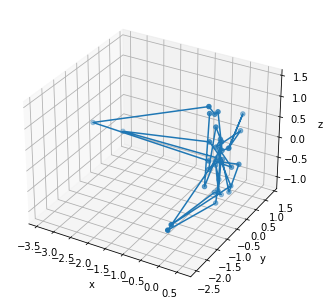

In [ ]:
ddp('tiny_gph.dat', showplot=True)

#### old code

In [ ]:
N_printed_sents = 200
nlp = spacy.load('en_core_web_lg')

with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
idx = []
result_subgraph = []
for i, (s1, s2) in enumerate(sentences_test):
    if len(s1) <3 or len(s2) < 3:
        result_subgraph.append(0)
        continue
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.


    #MDS on subgraph
    subgraph1 = distances[np.ix_(s1, s1)]
    subgraph2 = distances[np.ix_(s2, s2)]
    embed_subgraph1 = graph_embed(subgraph1, 3)
    embed_subgraph2 = graph_embed(subgraph2, 3)
    vsub1 = np.mean(embed_subgraph1, axis=0)
    vsub2 = np.mean(embed_subgraph2, axis=0)
    d2 = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    result_subgraph.append(d2)

    #print(d.shape)
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = nlp(sent1)
    sent1 = nlp(' '.join([str(t) for t in sent1 if not t.is_stop]))
    sent2 = nlp(sent2)
    sent2 = nlp(' '.join([str(t) for t in sent2 if not t.is_stop]))
    #sent1 = nlp(' '.join([word for word in sent1 if word not in english_stopwords]))
    #sent2 = nlp(' '.join([word for word in sent2 if word not in english_stopwords]))
    similarity = sent1.similarity(sent2)
    #if similarity < 0.4:
    print(i, "{:1.8f} {:1.8f} {:1.8f}".format(train[i] / 5, d, d2, similarity), lines_test[i], sep='\t')
    if i > N_printed_sents:
        break

NameError: name 'spacy' is not defined

In [ ]:
our_simlarity_n = 1-np.array([dist.cosine(np.mean(word_to_vec[s1,:], axis=0), np.mean(word_to_vec[s2,:], axis=0)) for (s1, s2) in sentences_test])/2
spacy_similarity_n = np.array([nlp(' '.join([str(t) for t in nlp(sent2) if not t.is_stop])).similarity(nlp(' '.join([str(t) for t in nlp(sent1) if not t.is_stop]))) for (sent1, sent2) in [s.split('\t') for s in lines_test]])
print(spacy_similarity_n[:10])

print(our_simlarity_n[:10])



[0.9237369  0.63757388 0.8347624  0.8160544  0.82062957 0.9536833
 0.81375333 0.79174104 0.82175876 1.        ]
[0.92187823 0.35590817 0.52993919 0.97916754 0.28898951 0.99434384
 0.69519802 0.67610976 0.51193864 0.98772491]


### 4.2 Pearson correlation coefficient
To estimate the quality of models we will use this coefficient, which is calculated as follows:
$$p_{XY} = \frac{\sigma_{XY}}{\sigma_X \cdot \sigma_Y}$$
where $p_{XY}$ is the Pearson correlation coefficient, $\sigma_Y, \sigma_X$ are standart deviations of $Y$ and $X$, and $\sigma_{XY}$ is the covariance between $X$ and $Y$ 


In [ ]:
#we normalize all the 
p_xy = np.corrcoef(train, spacy_similarity_n)
print("p_xy spacy train = ", p_xy[1, 0])
p_xy = np.corrcoef(our_simlarity_n, spacy_similarity_n)
print("p_xy spacy our_simlarity_n = ", p_xy[1, 0])
p_xy = np.corrcoef(train, our_simlarity_n)
print("p_xy our_simlarity_n train = ", p_xy[1, 0])


p_xy spacy train =  0.7131287525074835
p_xy spacy our_simlarity_n =  0.5395828515504087
p_xy our_simlarity_n train =  0.5113422409775331


### 4.3 Our comments on the results

As we can see the best quality we have for spacy built-in function which uses word-to-vec representation. The second best and not too far from spacy, is our implementation of MDS on the graph representation of all the sentences.
As it was expected 

## 5 Further researches and possible improvements

As an improvement one could use all the DG methods on the graph with <b>all the words</b> as in the MDS. 

Another problem that we had is that words from the dataset could close after lemmatizing when before they were not, and this problem is more pronounced when we have "strange" vocabulary as we have in our additional dataset. 

### Some other metrics(to remove)

In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

0.16965264574028385
0.007678251653702461
0.7751361274991766


In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

print('n')
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.16965264574028385
0.007678251653702461
0.7751361274991766
n
0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999


In [ ]:
 # _n for normalized
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999
